**Chapter 3: Geocentric Models**

The purpose of this notebook is to learn the Bayesian code from the [Statistical Rethinking book](https://xcelab.net/rm/statistical-rethinking/) using Python. I will use the R `rethinking` package as a point of comparison. Python code is primarily from [here](https://github.com/pymc-devs/resources/blob/master/Rethinking_2/) or  may be taken [here](https://github.com/aloctavodia/Statistical-Rethinking-with-Python-and-PyMC3).



In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pymc3 as pm
import scipy.stats as stats
import seaborn as sns

from scipy.interpolate import griddata

In [2]:
%load_ext nb_black
%config InlineBackend.figure_format = 'retina'
%load_ext watermark
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz

<IPython.core.display.Javascript object>

In [4]:
# Run R code for comparison of code
%load_ext rpy2.ipython

<IPython.core.display.Javascript object>

In [5]:
%%R                                       # All R cells will be indicated with %%R at the top of the cell
suppressMessages(library(tidyverse))
suppressMessages(library(rethinking))

<IPython.core.display.Javascript object>

# Epistimology vs. ontology

He mentions these terms a few times in the lecture and in the book. I looked up the definitions on Wikipedia.

**Epistemology** is the branch of philosophy concerned with knowledge. Epistemologists study the nature, origin, and scope of knowledge, epistemic justification, the rationality of belief, and various related issues

**Ontology** is the branch of philosophy that studies concepts such as existence, being, becoming, and reality. It includes the questions of how entities are grouped into basic categories and which of these entities exist on the most fundamental level.


# Code 4.1

Normal distribution by addition

## R

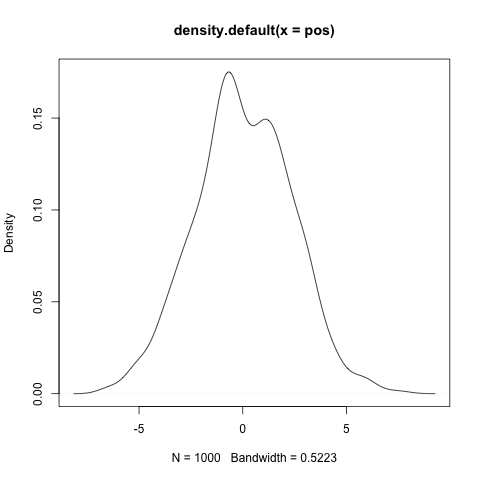

<IPython.core.display.Javascript object>

In [9]:
%%R

pos <- replicate( 1000 , sum( runif(16,-1,1) ) )
plot(density(pos))

## Python

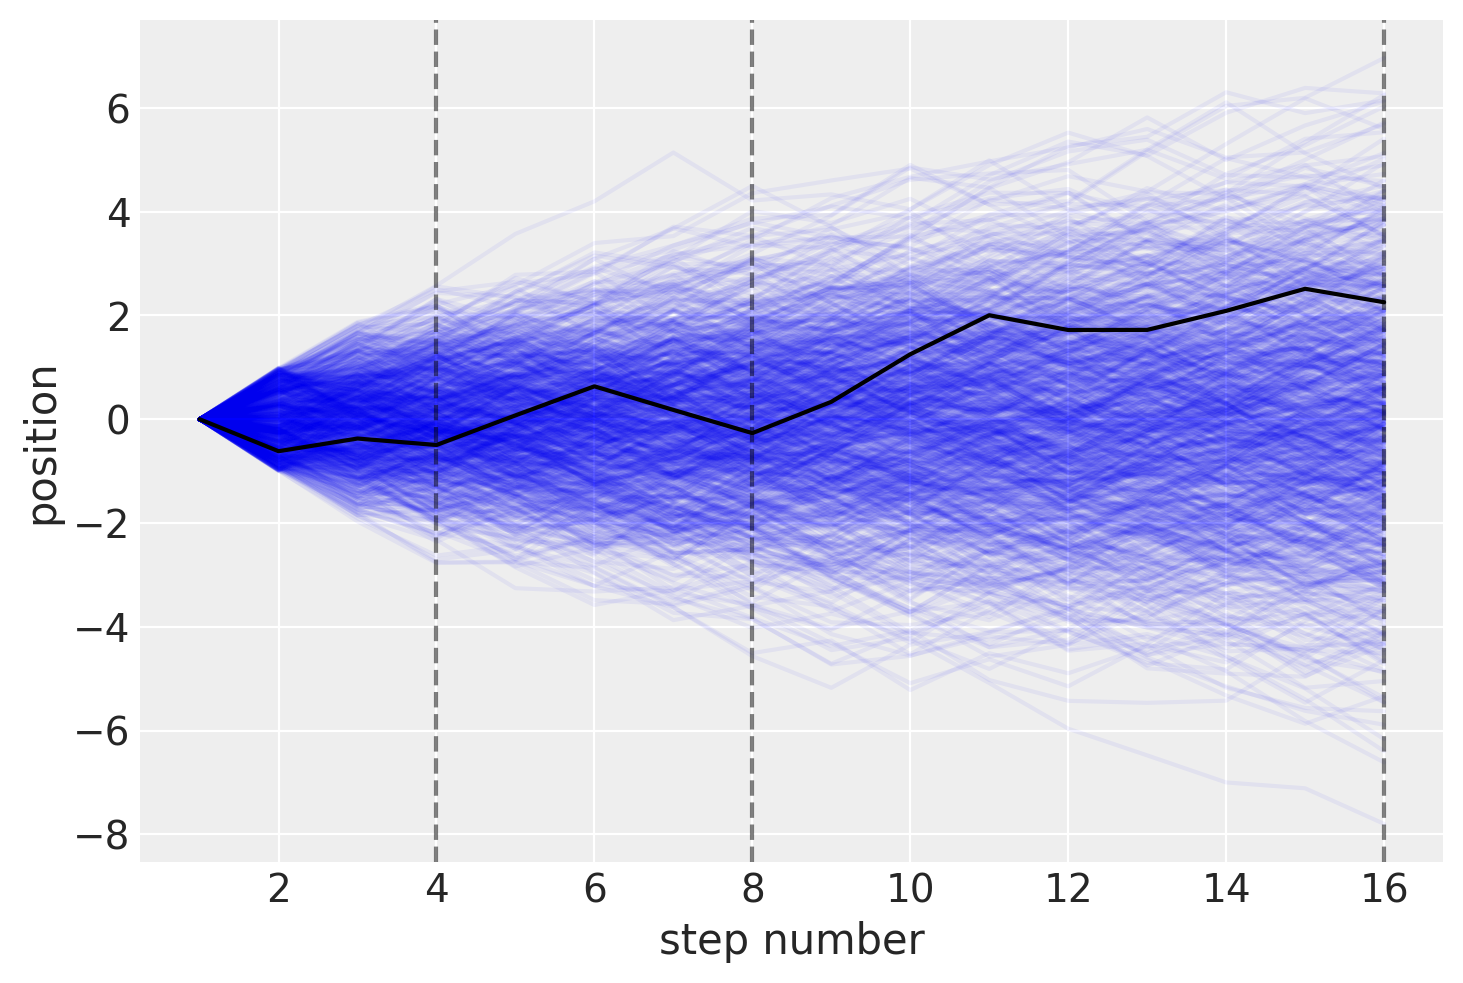

<IPython.core.display.Javascript object>

In [10]:
np.random.seed(1234)
steps = 16
repetitions = 1000
x = np.zeros([steps, repetitions])
for i in range(x.shape[1]):
    x[1:, i] = np.cumsum(np.random.uniform(-1, 1, steps - 1))

plt.plot(range(1, 17), x[:, :], c="b", alpha=0.05)
plt.plot(range(1, 17), x[:, 0], c="k")
plt.axvline(4, linestyle="--", c="k", alpha=0.5)
plt.axvline(8, linestyle="--", c="k", alpha=0.5)
plt.axvline(16, linestyle="--", c="k", alpha=0.5)
plt.xlabel("step number")
plt.ylabel("position")
plt.show()

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.01 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level functi

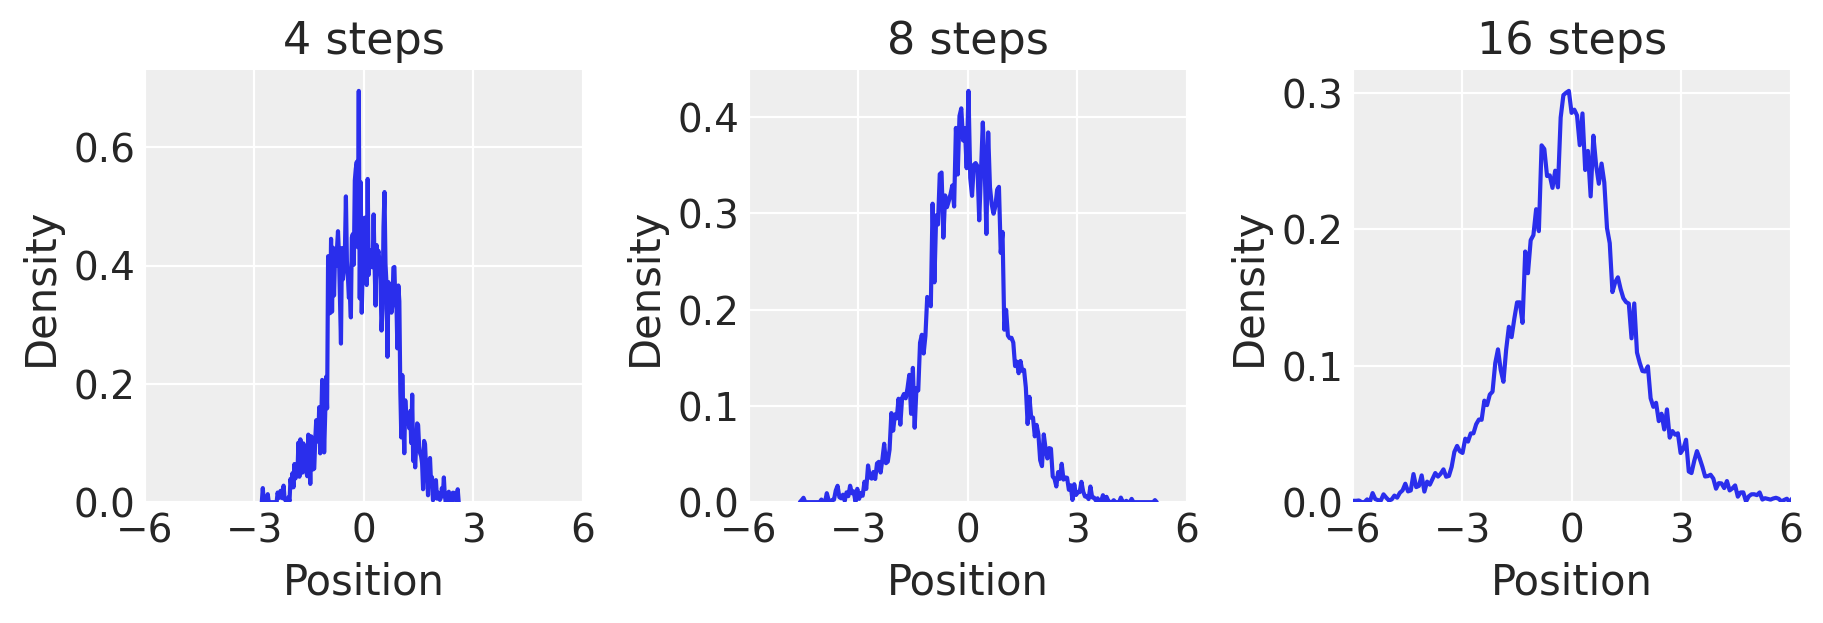

<IPython.core.display.Javascript object>

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(9, 3), sharex=True)
sns.distplot(x[1:4, :], kde_kws={"bw": 0.01}, ax=ax[0], hist=False)
sns.distplot(x[1:8, :], kde_kws={"bw": 0.01}, ax=ax[1], hist=False)
sns.distplot(x[1:, :], kde_kws={"bw": 0.01}, ax=ax[2], hist=False)

ax[0].set_title("4 steps")
ax[1].set_title("8 steps")
ax[2].set_title("16 steps")

for i in range(3):
    ax[i].set_ylabel("Density")
    ax[i].set_xlabel("Position")
    ax[i].set_xlim(-6, 6)
    ax[i].set_xticks([-6, -3, 0, 3, 6])

Text(0, 0.5, 'Density')

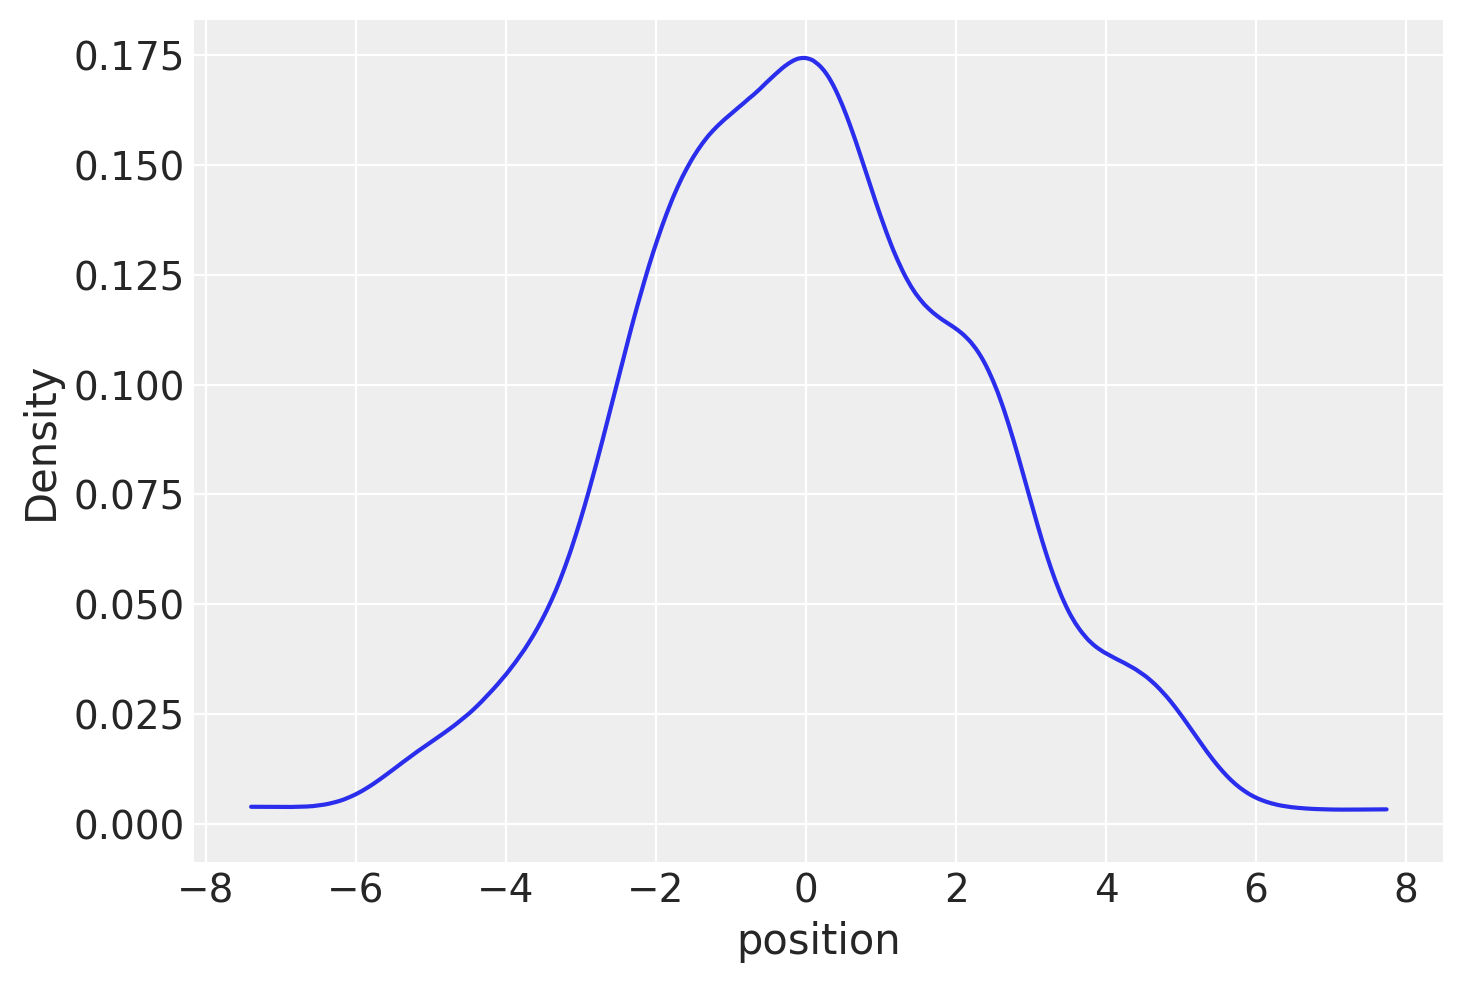

<IPython.core.display.Javascript object>

In [12]:
pos = np.random.uniform(-1, 1, size=(16, 1000)).sum(0)
az.plot_kde(pos)
plt.xlabel("position")
plt.ylabel("Density")

# Code 4.2 and 4.3

Normal by multiplication


## R

In [13]:
%%R

prod( 1 + runif(12,0,0.1) )

[1] 1.882201


<IPython.core.display.Javascript object>

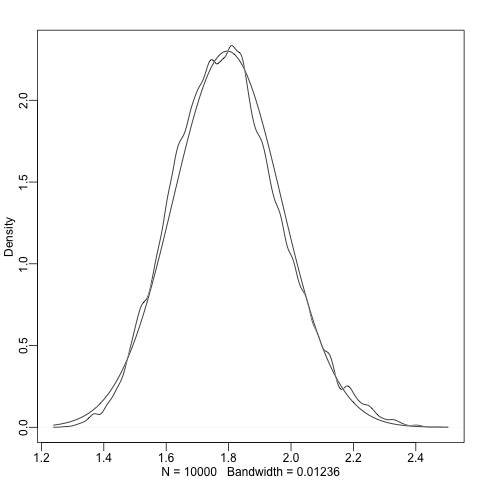

<IPython.core.display.Javascript object>

In [14]:
%%R
growth <- replicate( 10000 , prod( 1 + runif(12,0,0.1) ) )


dens( growth , norm.comp=TRUE )

## Python


<AxesSubplot:>

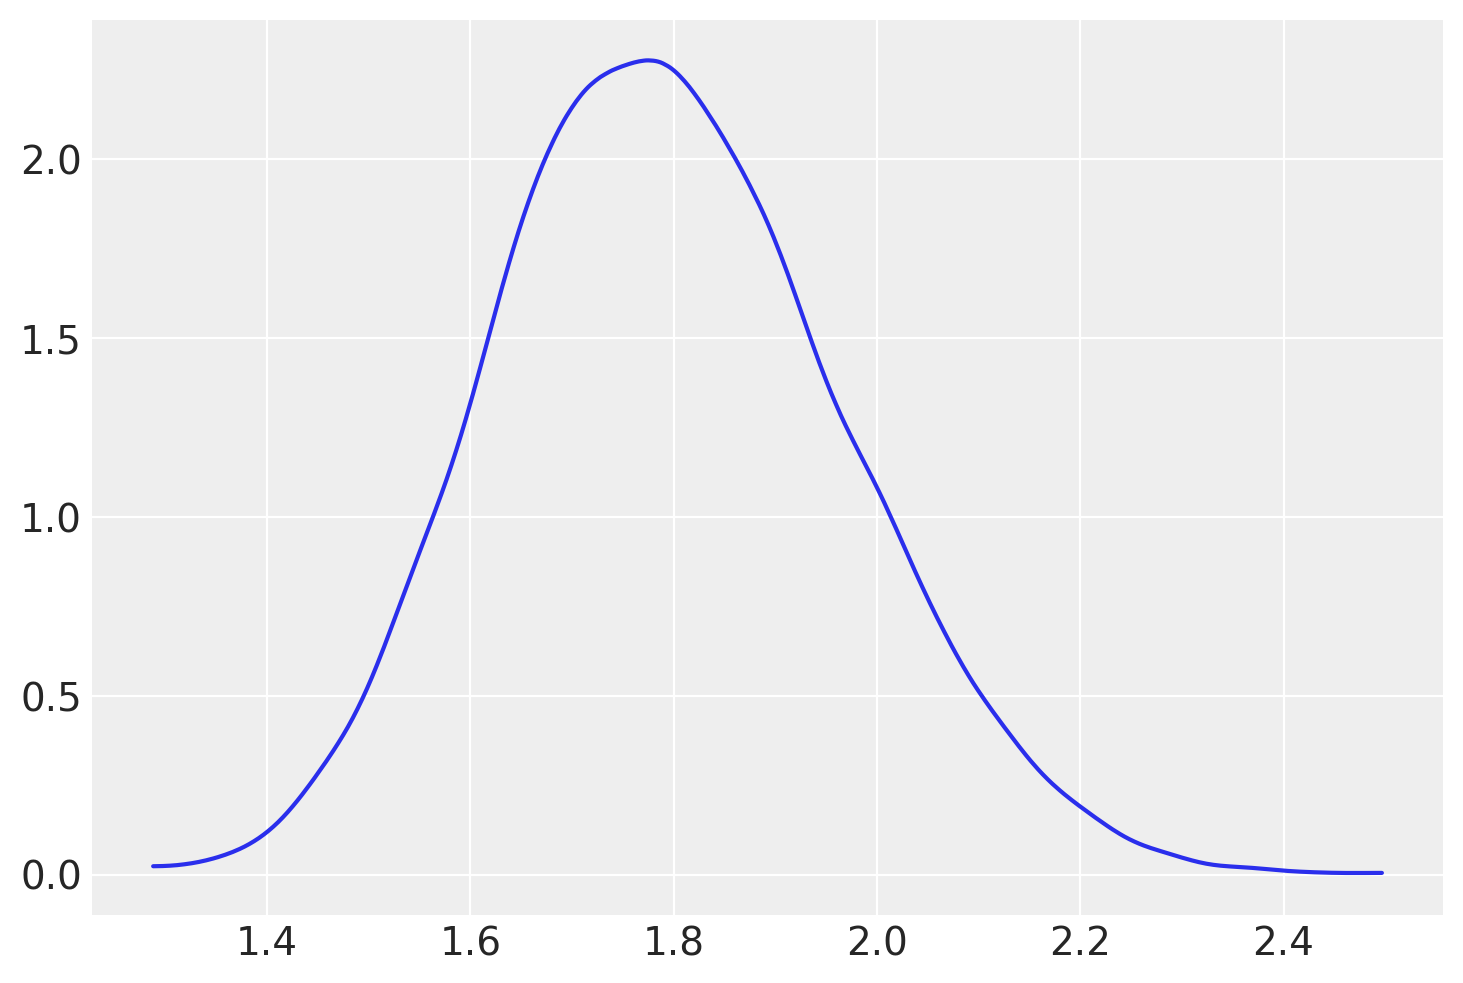

<IPython.core.display.Javascript object>

In [15]:
pos = np.random.uniform(1, 1.1, size=(12, 10000)).prod(0)
az.plot_kde(pos)

Sample from the posterior distribution. Explanation of `np.random.choice` function [here](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html).

# Code 4.4

Normal by multiplication


## R

In [16]:
%%R

big <- replicate( 10000 , prod( 1 + runif(12,0,0.5) ) )
small <- replicate( 10000 , prod( 1 + runif(12,0,0.01) ) )

<IPython.core.display.Javascript object>

## Python


<AxesSubplot:>

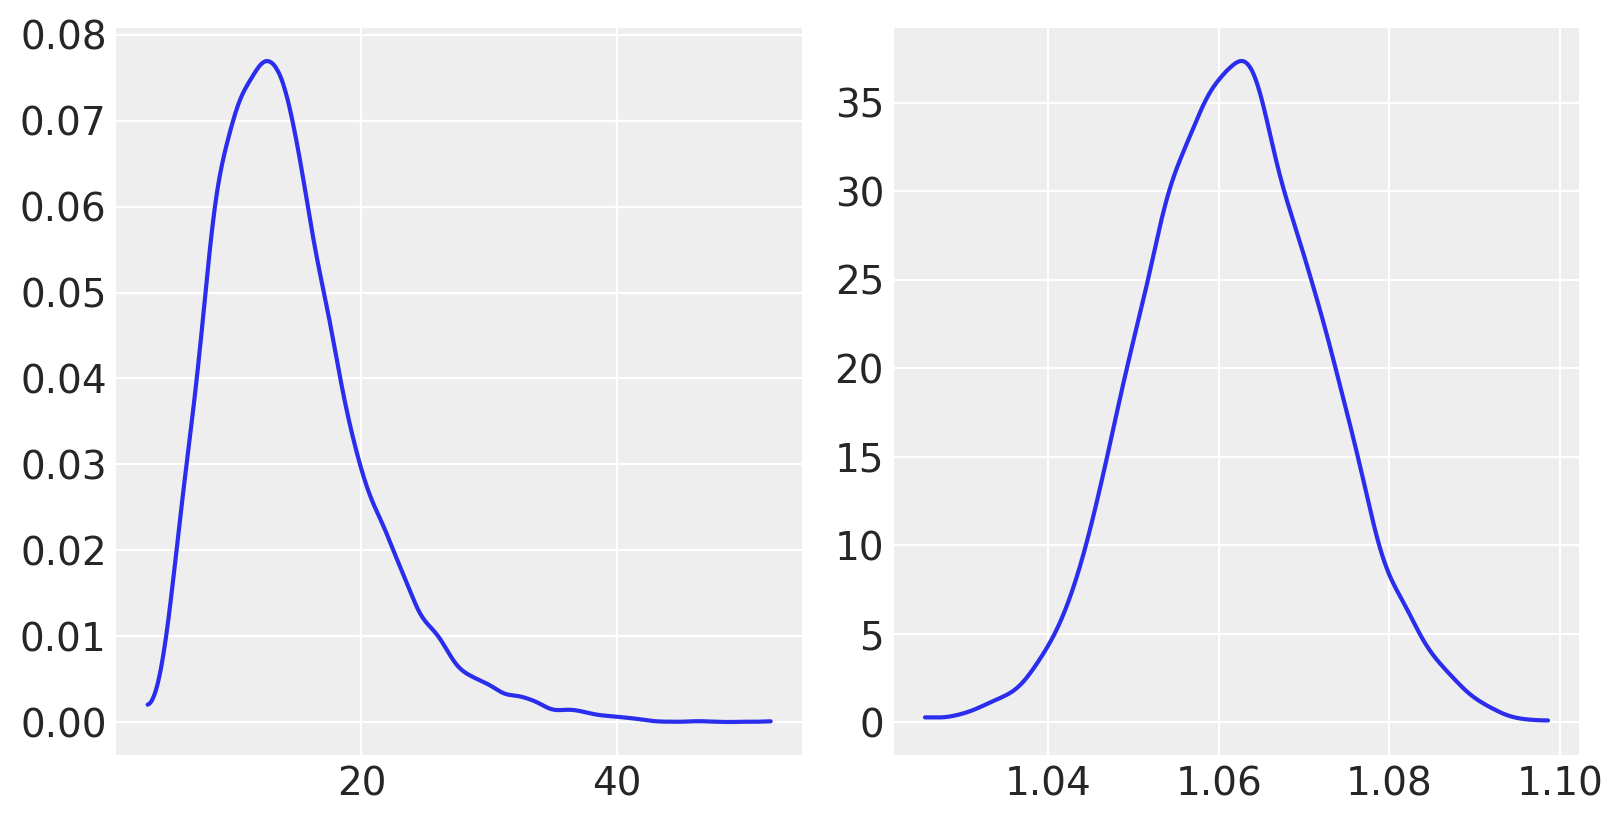

<IPython.core.display.Javascript object>

In [17]:
big = np.random.uniform(1, 1.5, size=(12, 10000)).prod(0)
small = np.random.uniform(1, 1.01, size=(12, 10000)).prod(0)
_, ax = plt.subplots(1, 2, figsize=(8, 4))
az.plot_kde(big, ax=ax[0])
az.plot_kde(small, ax=ax[1])

# Code 4.5

Normal by log-multiplication


## R

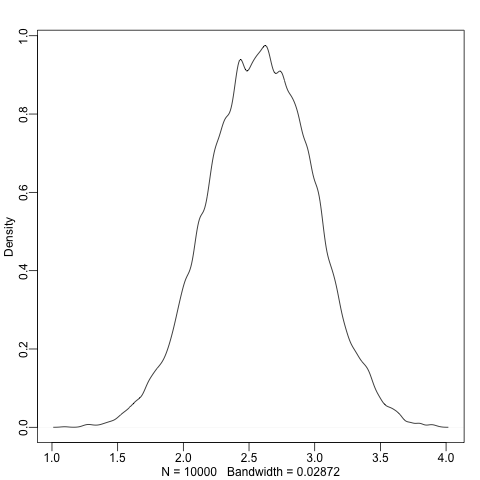

<IPython.core.display.Javascript object>

In [18]:
%%R

log.big <- replicate( 10000 , log(prod(1 + runif(12,0,0.5))) )

dens(log.big)

## Python


<AxesSubplot:>

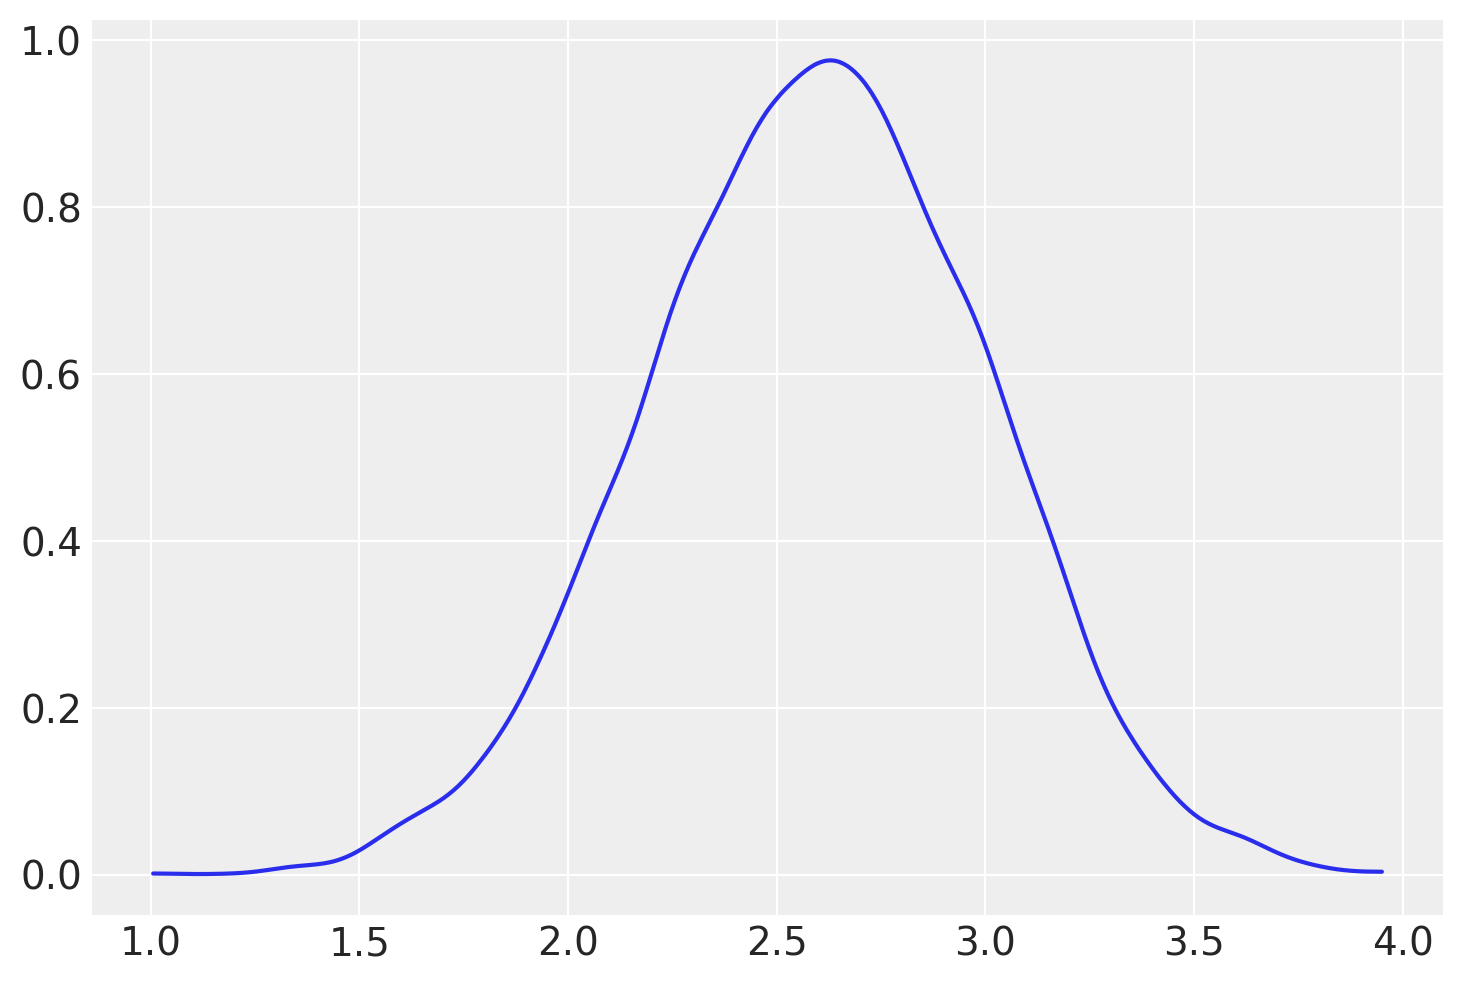

<IPython.core.display.Javascript object>

In [19]:
log_big = np.log(np.random.uniform(1, 1.5, size=(12, 10000)).prod(0))
az.plot_kde(log_big)

# Code 4.6

Normal by multiplication


## R

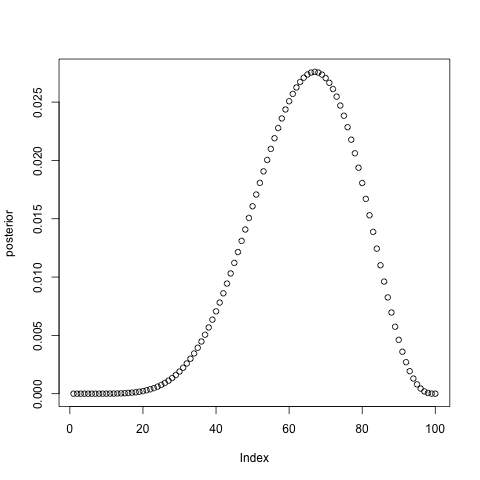

<IPython.core.display.Javascript object>

In [20]:
%%R

w <- 6; n <- 9;

p_grid <- seq(from=0,to=1,length.out=100)
posterior <- dbinom(w,n,p_grid)*dunif(p_grid,0,1)
posterior <- posterior/sum(posterior)

plot(posterior)

## Python


Text(0, 0.5, 'Density')

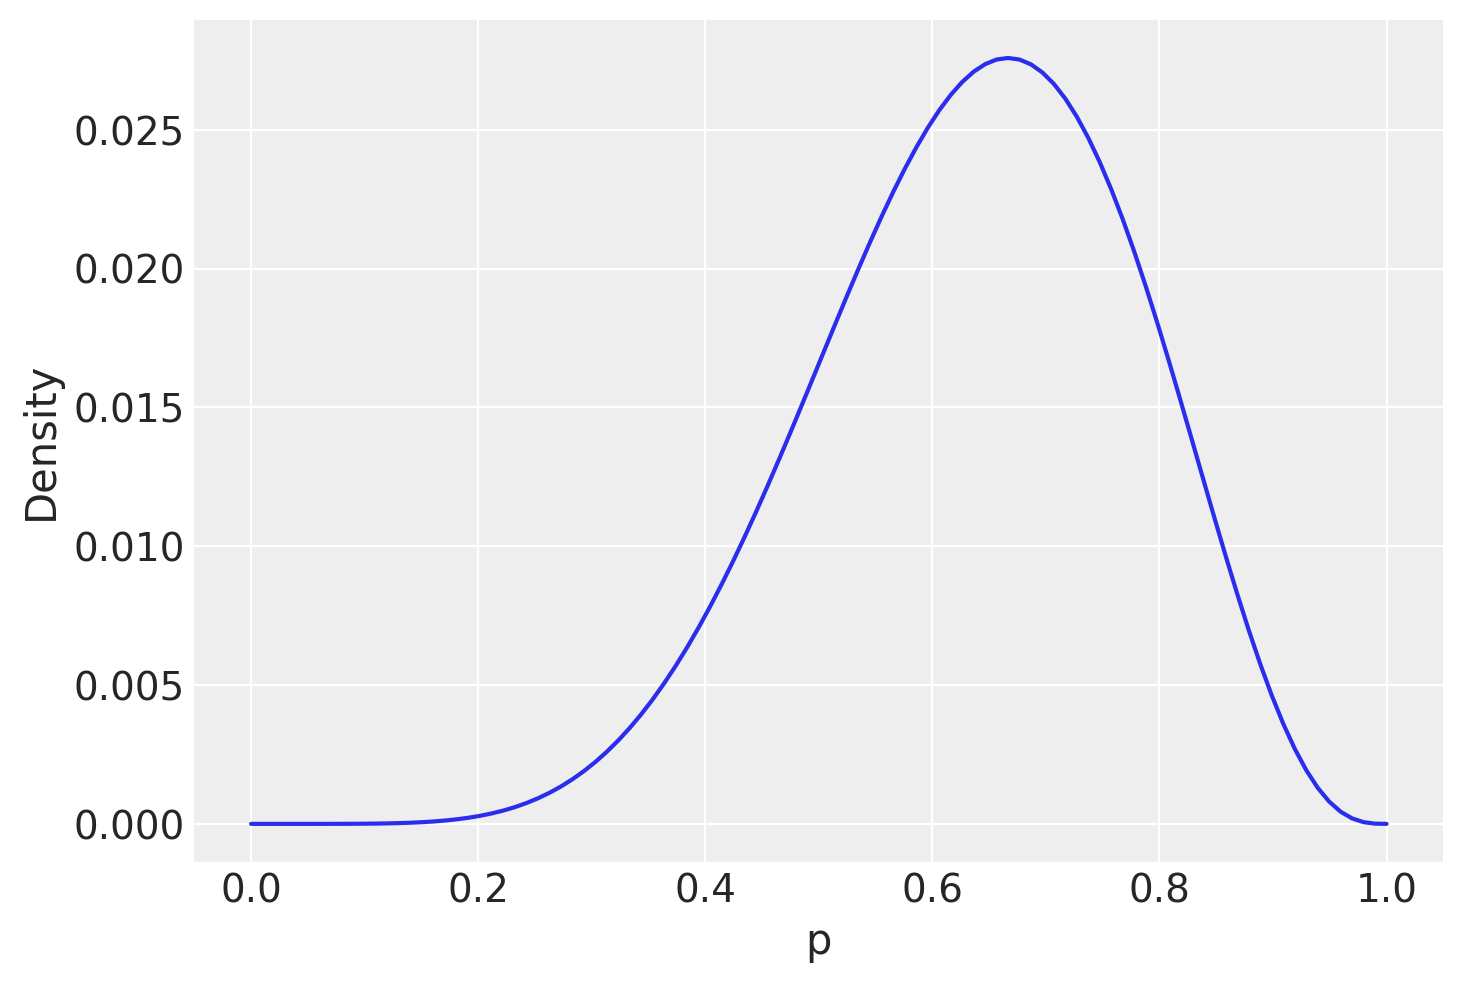

<IPython.core.display.Javascript object>

In [21]:
w, n = 6, 9
p_grid = np.linspace(0, 1, 100)
posterior = stats.binom.pmf(k=w, n=n, p=p_grid) * stats.uniform.pdf(p_grid, 0, 1)
posterior = posterior / (posterior).sum()
plt.plot(p_grid, posterior)
plt.xlabel("p")
plt.ylabel("Density")

# Code 4.7 and 4.8

Using the Howell data for weights and heights.

## R

In [22]:
%%R

library(rethinking)
data(Howell1)
d <- Howell1

str(d)

head(d)

'data.frame':	544 obs. of  4 variables:
 $ height: num  152 140 137 157 145 ...
 $ weight: num  47.8 36.5 31.9 53 41.3 ...
 $ age   : num  63 63 65 41 51 35 32 27 19 54 ...
 $ male  : int  1 0 0 1 0 1 0 1 0 1 ...
   height   weight age male
1 151.765 47.82561  63    1
2 139.700 36.48581  63    0
3 136.525 31.86484  65    0
4 156.845 53.04191  41    1
5 145.415 41.27687  51    0
6 163.830 62.99259  35    1


<IPython.core.display.Javascript object>

## Python


In [23]:
d = pd.read_csv("../data/a_input/Howell1.csv", sep=";", header=0)
d.head()

height     weight   age  male
0  151.765  47.825606  63.0     1
1  139.700  36.485807  63.0     0
2  136.525  31.864838  65.0     0
3  156.845  53.041914  41.0     1
4  145.415  41.276872  51.0     0

<IPython.core.display.Javascript object>

# Code 4.9

Summarize data

## R

In [24]:
%%R

precis(d)

'data.frame': 544 obs. of 4 variables:
         mean    sd  5.5%  94.5%     histogram
height 138.26 27.60 81.11 165.74 ▁▁▁▁▁▁▁▂▁▇▇▅▁
weight  35.61 14.72  9.36  54.50 ▁▂▃▂▂▂▂▅▇▇▃▂▁
age     29.34 20.75  1.00  66.13     ▇▅▅▃▅▂▂▁▁
male     0.47  0.50  0.00   1.00    ▇▁▁▁▁▁▁▁▁▇


<IPython.core.display.Javascript object>

## Python


In [25]:
# Summary with pandas
d.describe()

height      weight         age        male
count  544.000000  544.000000  544.000000  544.000000
mean   138.263596   35.610618   29.344393    0.472426
std     27.602448   14.719178   20.746888    0.499699
min     53.975000    4.252425    0.000000    0.000000
25%    125.095000   22.007717   12.000000    0.000000
50%    148.590000   40.057844   27.000000    0.000000
75%    157.480000   47.209005   43.000000    1.000000
max    179.070000   62.992589   88.000000    1.000000

<IPython.core.display.Javascript object>

In [26]:
# Summary with arviz to match R output
az.summary(d.to_dict(orient="list"), kind="stats")

mean      sd  hdi_5.5%  hdi_94.5%
height  138.264  27.602    90.805    170.180
weight   35.611  14.719    11.368     55.707
age      29.344  20.747     0.000     57.000
male      0.472   0.500     0.000      1.000

<IPython.core.display.Javascript object>

# Code 4.10 and 4.11


## R

In [27]:
%%R

head(d$height, 20)

 [1] 151.7650 139.7000 136.5250 156.8450 145.4150 163.8300 149.2250 168.9100
 [9] 147.9550 165.1000 154.3050 151.1300 144.7800 149.9000 150.4950 163.1950
[17] 157.4800 143.9418 121.9200 105.4100


<IPython.core.display.Javascript object>

In [28]:
%%R

d2 <- d[ d$age >= 18 , ]

<IPython.core.display.Javascript object>

## Python


In [29]:
d["height"]

0      151.765
1      139.700
2      136.525
3      156.845
4      145.415
        ...   
539    145.415
540    162.560
541    156.210
542     71.120
543    158.750
Name: height, Length: 544, dtype: float64

<IPython.core.display.Javascript object>

In [30]:
d2 = d[d["height"] >= 18].copy()

<IPython.core.display.Javascript object>

# Code 4.12

Goal is to model these values using a Gaussian distribution.

Whatever the prior, it’s a very good idea to plot your priors, so you have a sense of the assumption they build into the model.

## R

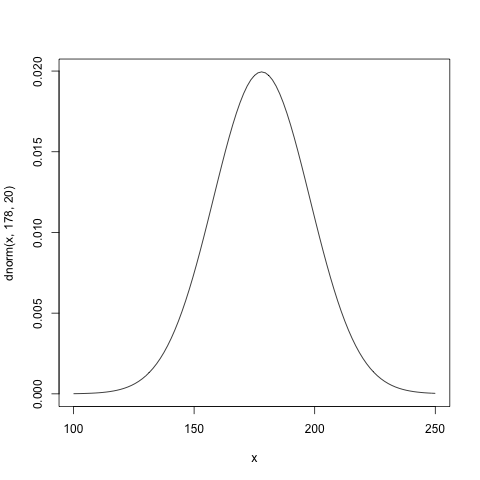

<IPython.core.display.Javascript object>

In [31]:
%%R

curve( dnorm( x , 178 , 20 ) , from=100 , to=250 )

## Python


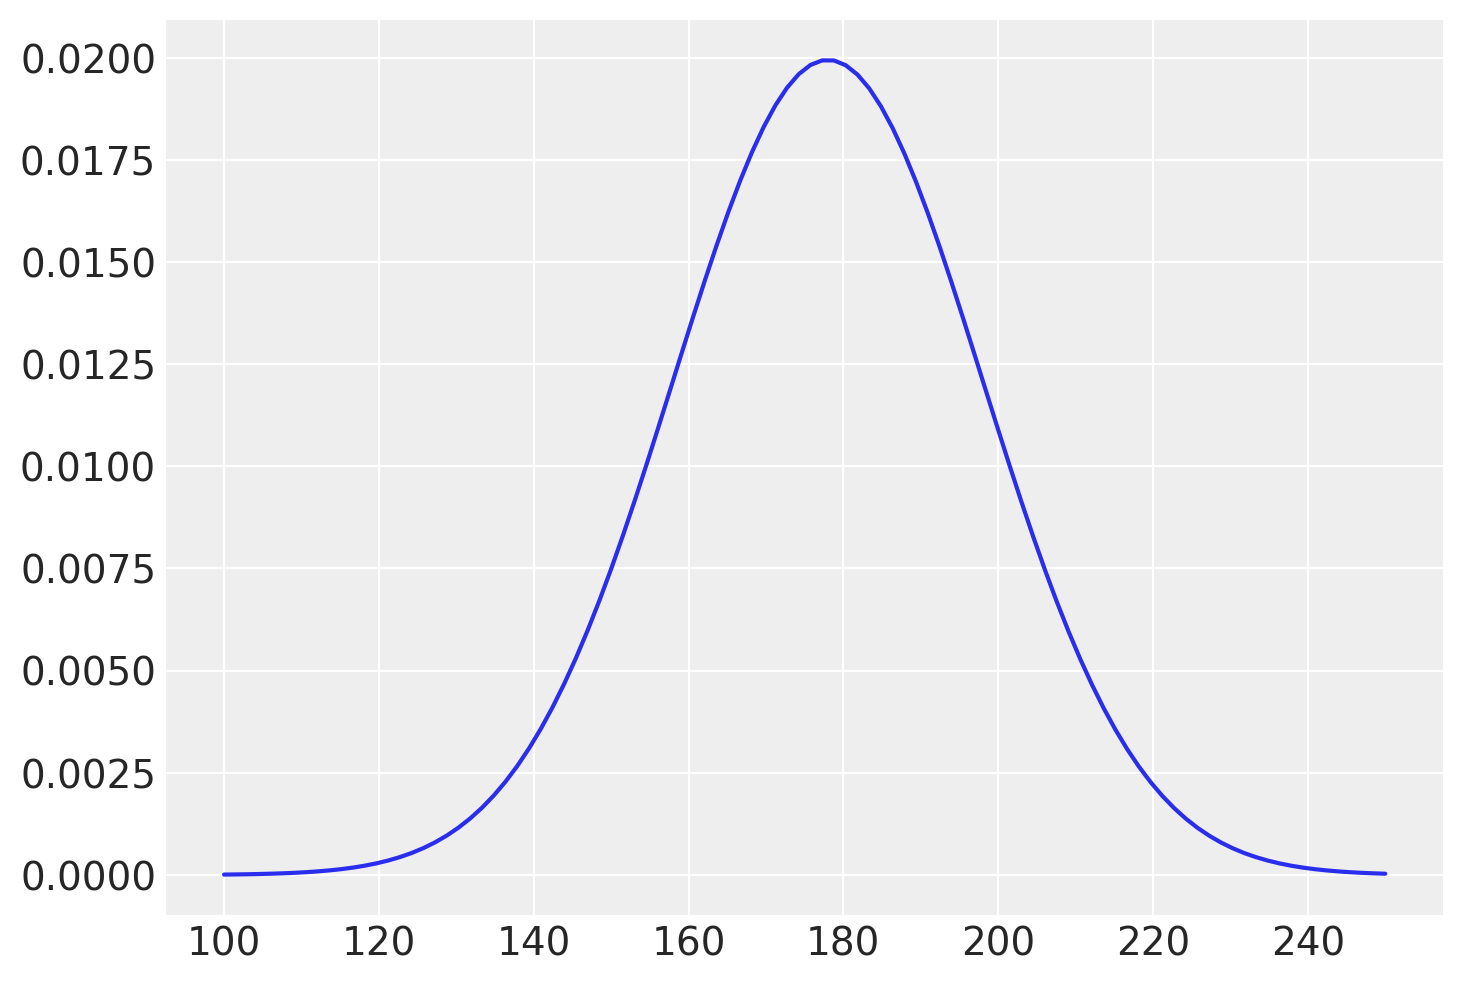

<IPython.core.display.Javascript object>

In [32]:
x = np.linspace(100, 250, 100)
plt.plot(x, stats.norm.pdf(x, 178, 20))

# Code 4.13

The σ prior is a truly flat prior, a uniform one, that functions just to constrain σ to have positive probability between zero and 50 cm. 


## R

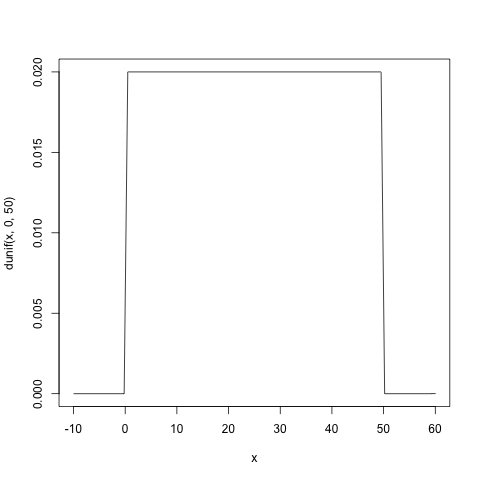

<IPython.core.display.Javascript object>

In [51]:
%%R

curve( dunif( x , 0 , 50 ) , from=-10 , to=60 )

## Python


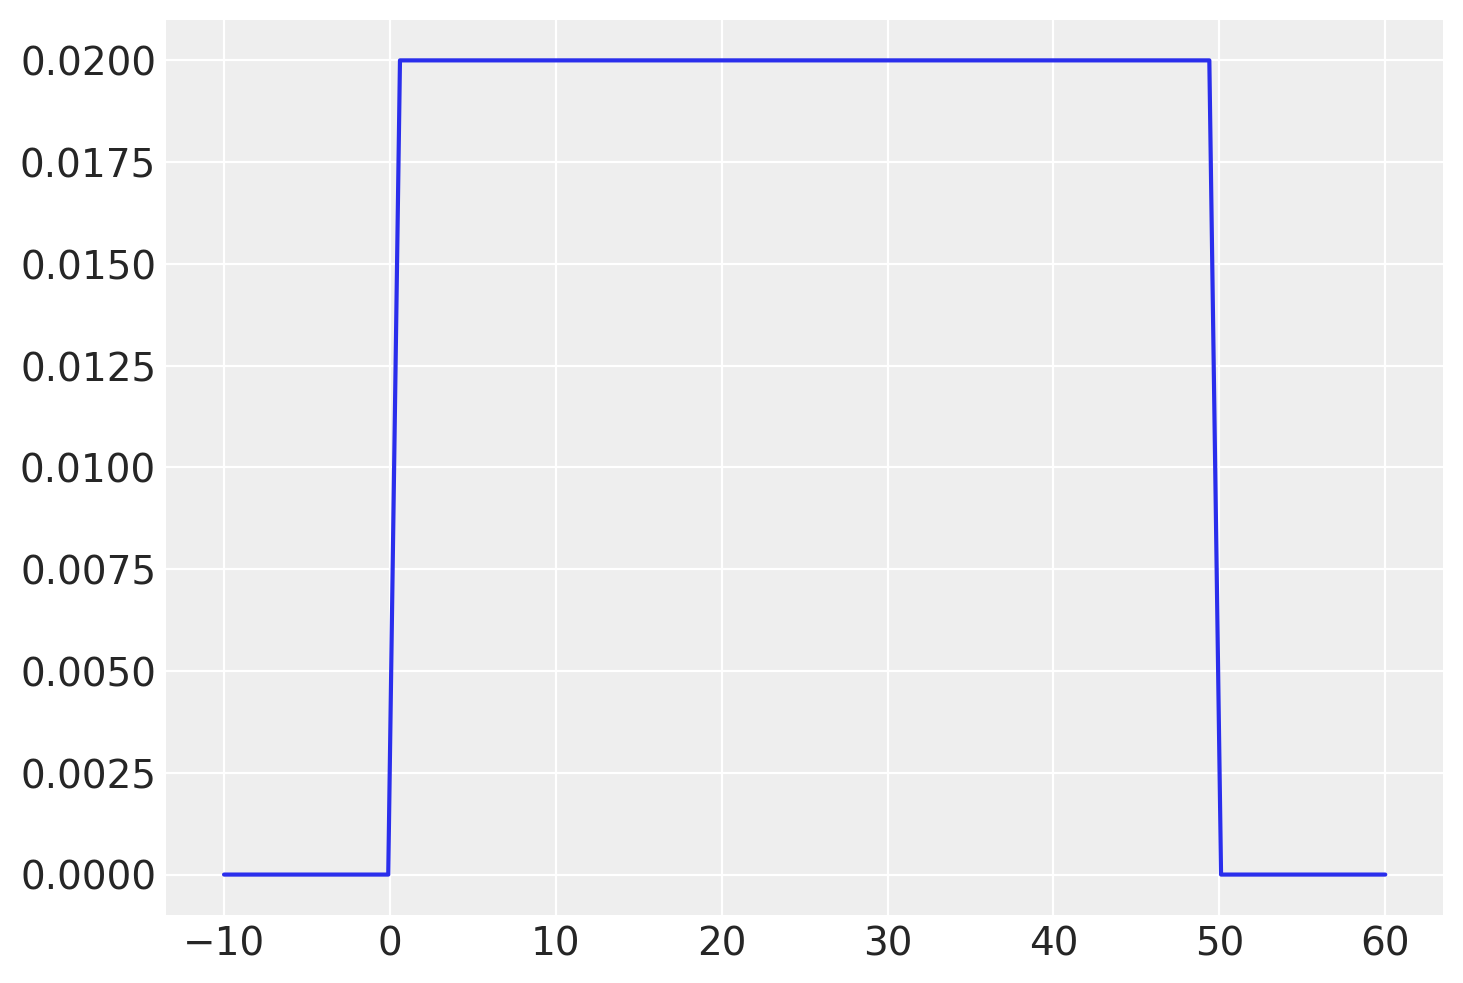

<IPython.core.display.Javascript object>

In [34]:
x = np.linspace(-10, 60, 100)
plt.plot(x, stats.uniform.pdf(x, 0, 50))

# Code 4.14

Prior predictive simulation is an essential part of modeling.

## R

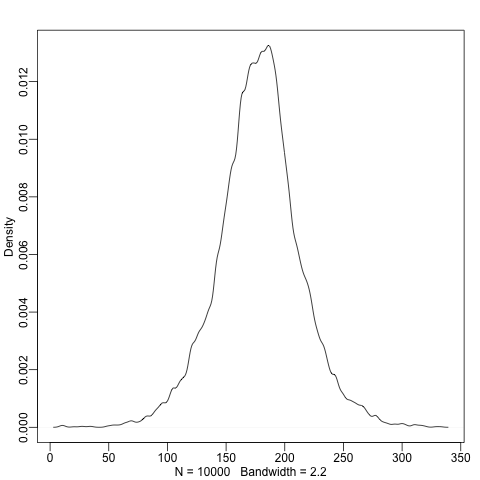

<IPython.core.display.Javascript object>

In [78]:
%%R

sample_mu <- rnorm( 1e4 , 178 , 20 )
sample_sigma <- runif( 1e4 , 0 , 50 )
prior_h <- rnorm( 1e4 , sample_mu , sample_sigma )
dens( prior_h )

## Python


([], [])

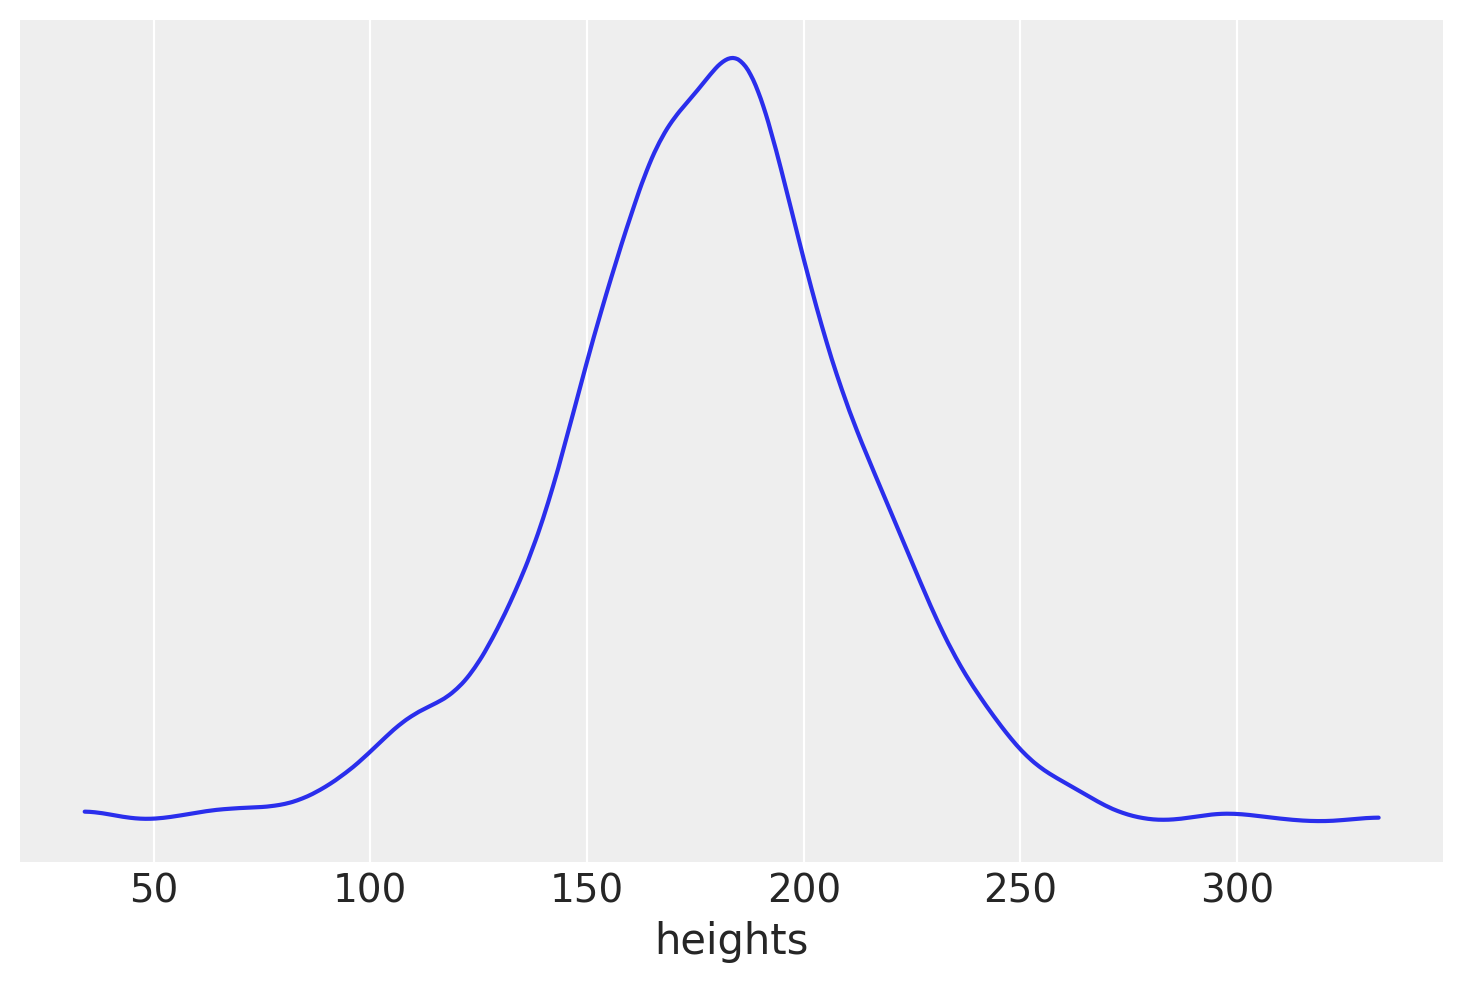

<IPython.core.display.Javascript object>

In [36]:
n_samples = 1000
sample_mu = stats.norm.rvs(loc=178, scale=20, size=n_samples)
sample_sigma = stats.uniform.rvs(loc=0, scale=50, size=n_samples)
prior_h = stats.norm.rvs(loc=sample_mu, scale=sample_sigma)
az.plot_kde(prior_h)
plt.xlabel("heights")
plt.yticks([])

# Code 4.15

Prior predictive simulation is very useful for assigning sensible priors, because it can be quite hard to anticipate how priors influence the observable variables. As an example, consider a much flatter and less informative prior for μ, like μ ~ Normal(178, 100)

## R

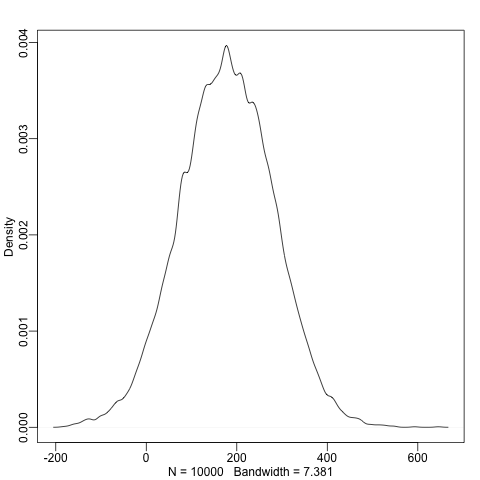

<IPython.core.display.Javascript object>

In [79]:
%%R

sample_mu <- rnorm( 1e4 , 178 , 100 )
prior_h <- rnorm( 1e4 , sample_mu , sample_sigma )
dens( prior_h )

## Python


([], [])

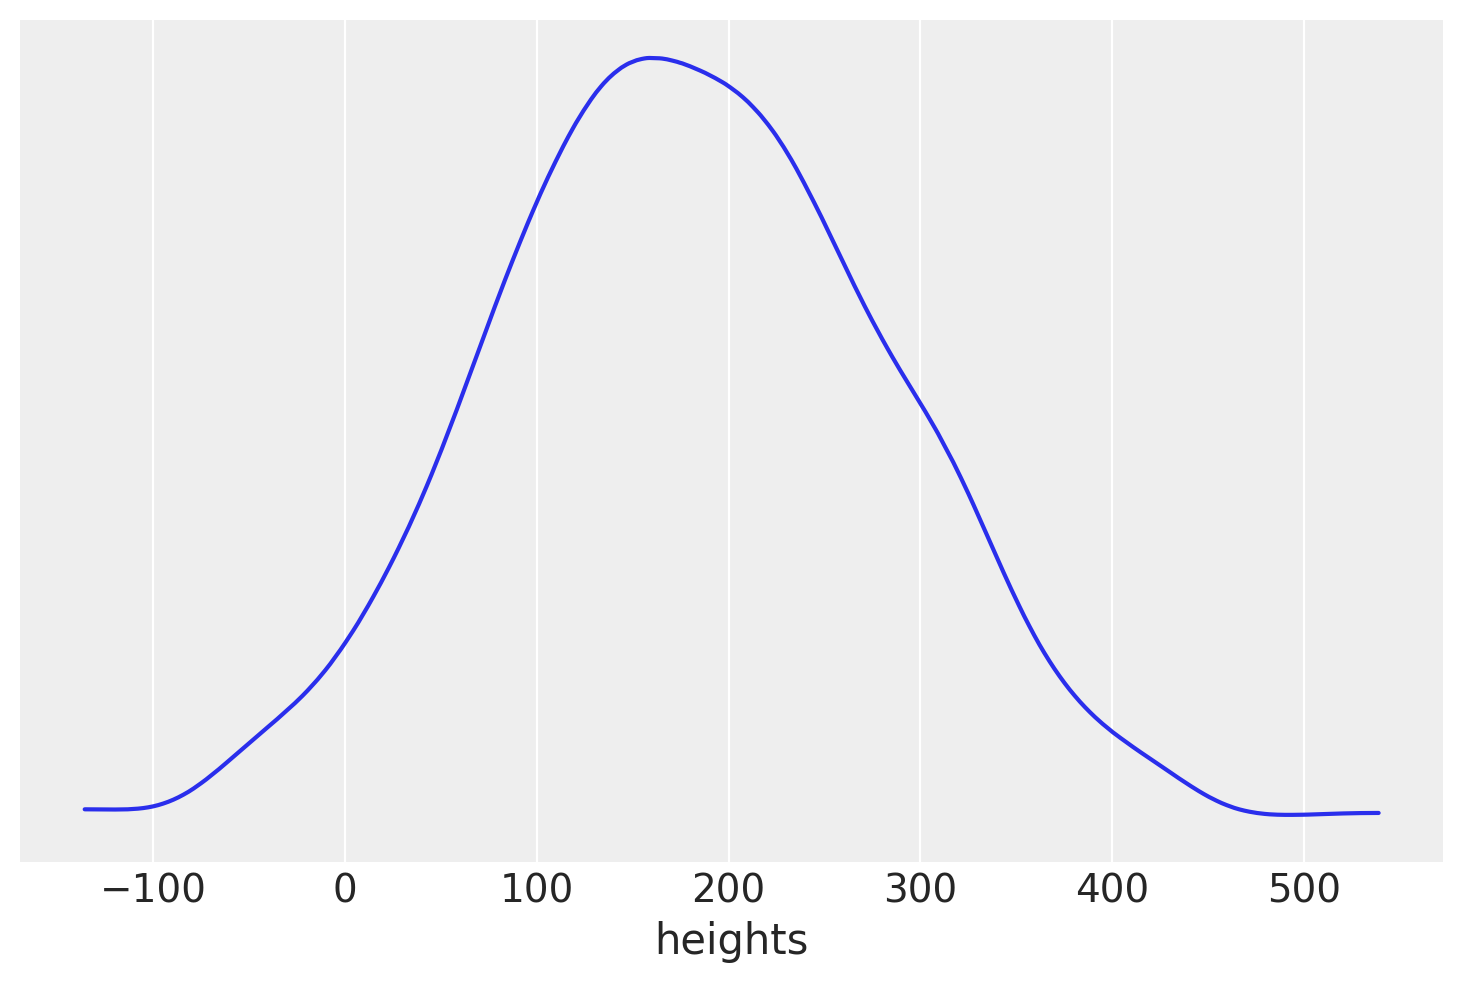

<IPython.core.display.Javascript object>

In [38]:
n_samples = 1000
sample_mu = stats.norm.rvs(loc=178, scale=100, size=n_samples)
prior_h = stats.norm.rvs(loc=sample_mu, scale=sample_sigma)
az.plot_kde(prior_h)
plt.xlabel("heights")
plt.yticks([])

We see negative, non-sensical heights with this bad prior!

# Code 4.16

Grid approximation of the posterior distriubtion. (Not to be used moving forward.)


## R

In [80]:
%%R

mu.list <- seq( from=150, to=160 , length.out=100 )

sigma.list <- seq( from=7 , to=9 , length.out=100 )

post <- expand.grid( mu=mu.list , sigma=sigma.list )

post$LL <- sapply( 1:nrow(post) , function(i) sum( 
    dnorm( d2$height , post$mu[i] , post$sigma[i] , log=TRUE ) ) )

post$prod <- post$LL + dnorm( post$mu , 178 , 20 , TRUE ) + dunif( post$sigma , 0 , 50 , TRUE )
                  
post$prob <- exp( post$prod - max(post$prod) )

<IPython.core.display.Javascript object>

In [59]:
%%R

mu.list <- seq( from=150, to=160 , length.out=100 )
sigma.list <- seq( from=7 , to=9 , length.out=100 )
post <- expand.grid( mu=mu.list , sigma=sigma.list )
post$LL <- sapply( 1:nrow(post) , function(i) sum(
    dnorm( d2$height , post$mu[i] , post$sigma[i] , log=TRUE ) ) )
post$prod <- post$LL + dnorm( post$mu , 178 , 20 , TRUE ) +
    dunif( post$sigma , 0 , 50 , TRUE )
post$prob <- exp( post$prod - max(post$prod) )

<IPython.core.display.Javascript object>

## Python


In [40]:
post = np.mgrid[150:160:0.05, 7:9:0.05].reshape(2, -1).T

likelihood = [
    sum(stats.norm.logpdf(d2.height, loc=post[:, 0][i], scale=post[:, 1][i]))
    for i in range(len(post))
]

post_prod = (
    likelihood
    + stats.norm.logpdf(post[:, 0], loc=178, scale=20)
    + stats.uniform.logpdf(post[:, 1], loc=0, scale=50)
)
post_prob = np.exp(post_prod - max(post_prod))



<IPython.core.display.Javascript object>

# Code 4.17 and 4.18

Normal by multiplication


## R

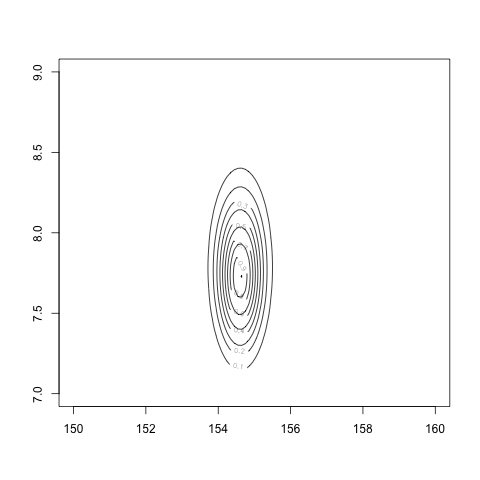

<IPython.core.display.Javascript object>

In [81]:
%%R

contour_xyz( post$mu , post$sigma , post$prob )

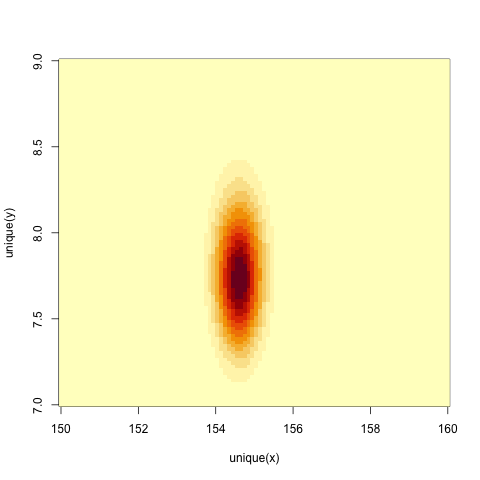

<IPython.core.display.Javascript object>

In [82]:
%%R

image_xyz( post$mu , post$sigma , post$prob )

## Python

Something went wrong here?

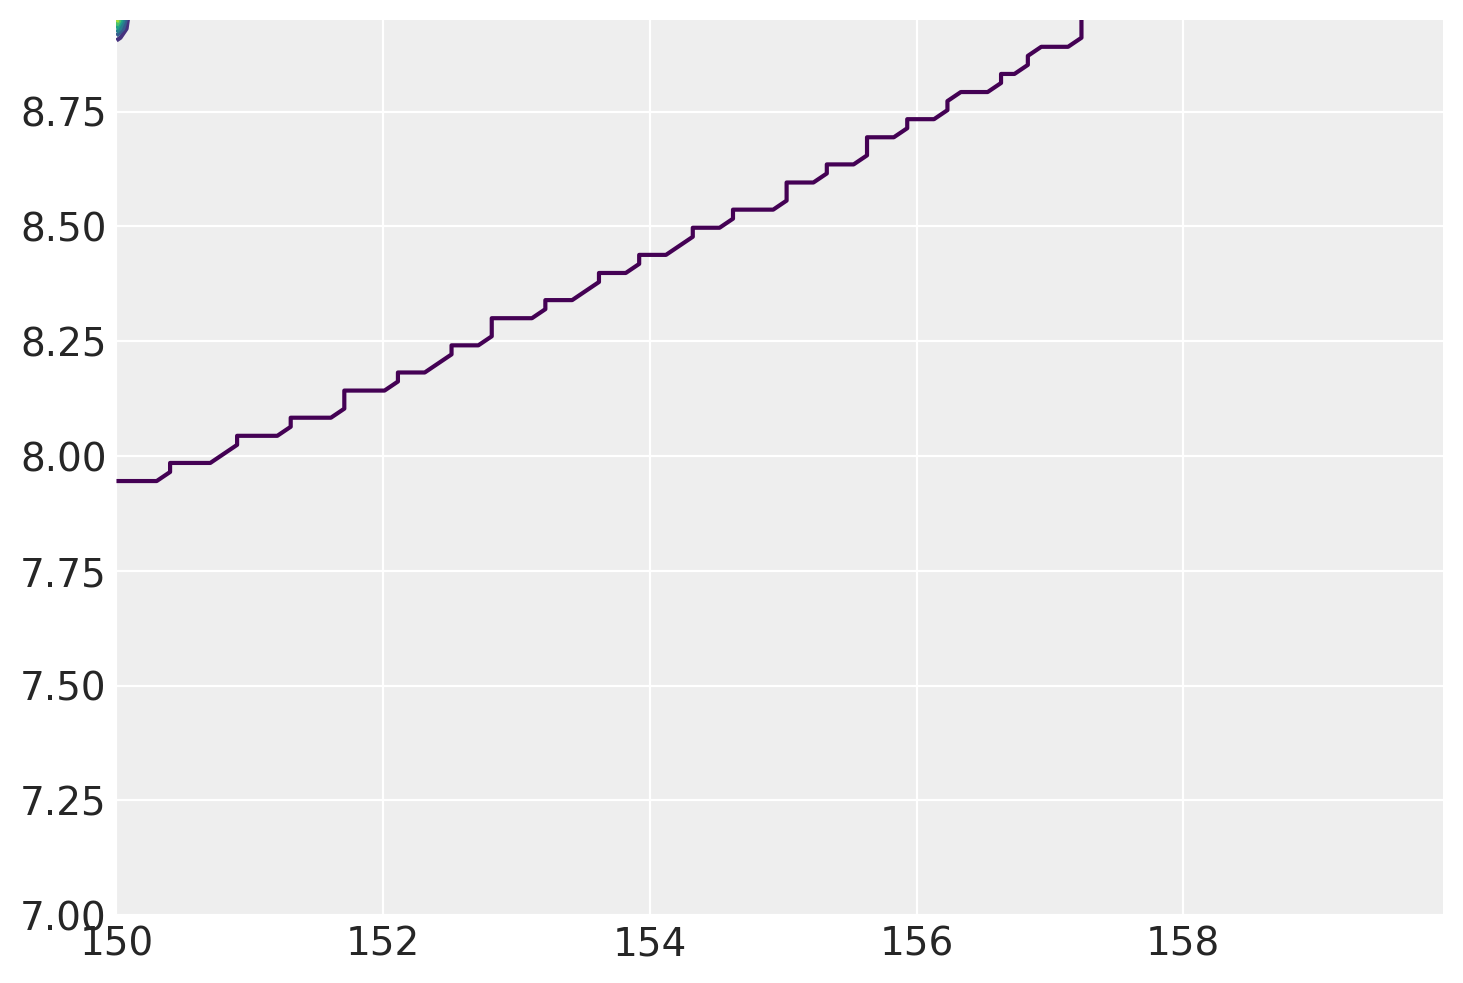

<IPython.core.display.Javascript object>

In [43]:
xi = np.linspace(post[:, 0].min(), post[:, 0].max(), 100)
yi = np.linspace(post[:, 1].min(), post[:, 1].max(), 100)
zi = griddata((post[:, 0], post[:, 1]), post_prob, (xi[None, :], yi[:, None]))

plt.contour(xi, yi, zi)

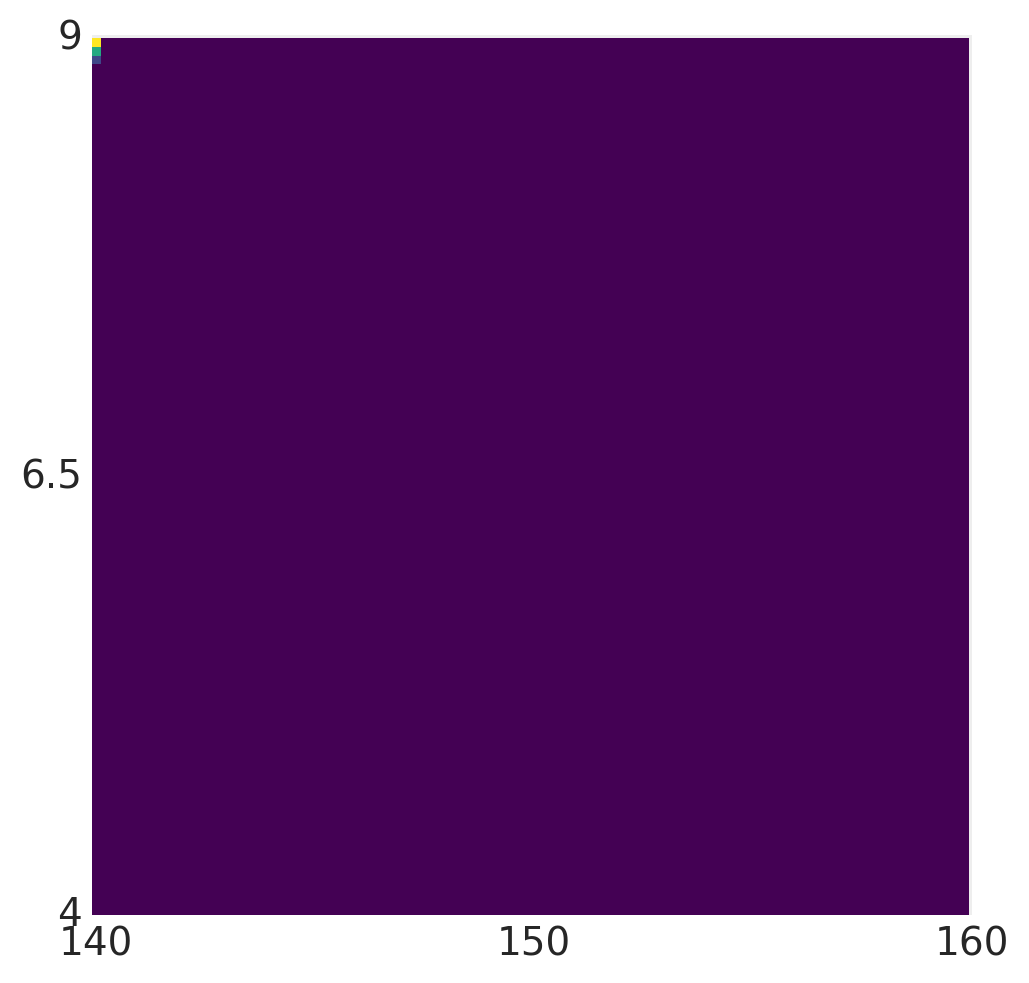

<IPython.core.display.Javascript object>

In [44]:

_, ax = plt.subplots()
ax.imshow(zi, origin="lower")
ax.set_xticks([0, 50, 100])
ax.set_xticklabels([140, 150, 160])
ax.set_yticks([0, 50, 100])
ax.set_yticklabels([4, 6.5, 9])
ax.grid(False);



# Code 4.19 and 4.20

Sampling from the posterior (two parameters)

## R

In [83]:
%%R

sample.rows <- sample( 1:nrow(post) , size=1e4 , replace=TRUE ,
    prob=post$prob )
sample.mu <- post$mu[ sample.rows ]
sample.sigma <- post$sigma[ sample.rows ]

<IPython.core.display.Javascript object>

[1] 3244 4048 5143 5746 3942 1746
[1] 154.3434 154.7475 154.2424 154.5455 154.1414 154.5455
[1] 7.646465 7.808081 8.030303 8.151515 7.787879 7.343434


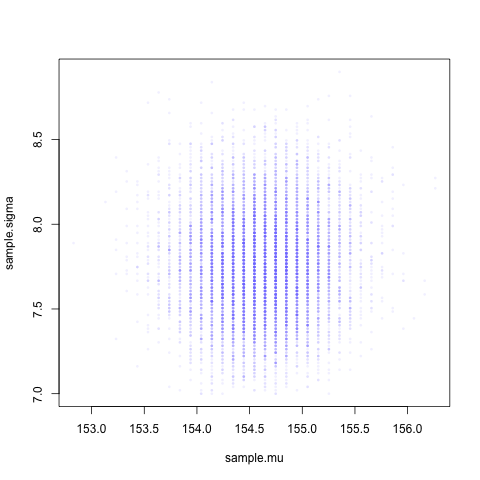

<IPython.core.display.Javascript object>

In [84]:
%%R

print(head(sample.rows))

print(head(sample.mu))

print(head(sample.sigma))

plot( sample.mu , sample.sigma , cex=0.5 , pch=16 , col=col.alpha(rangi2,0.1) )
# Plot isn't showing up exactly the same

## Python (not showing like repo example)


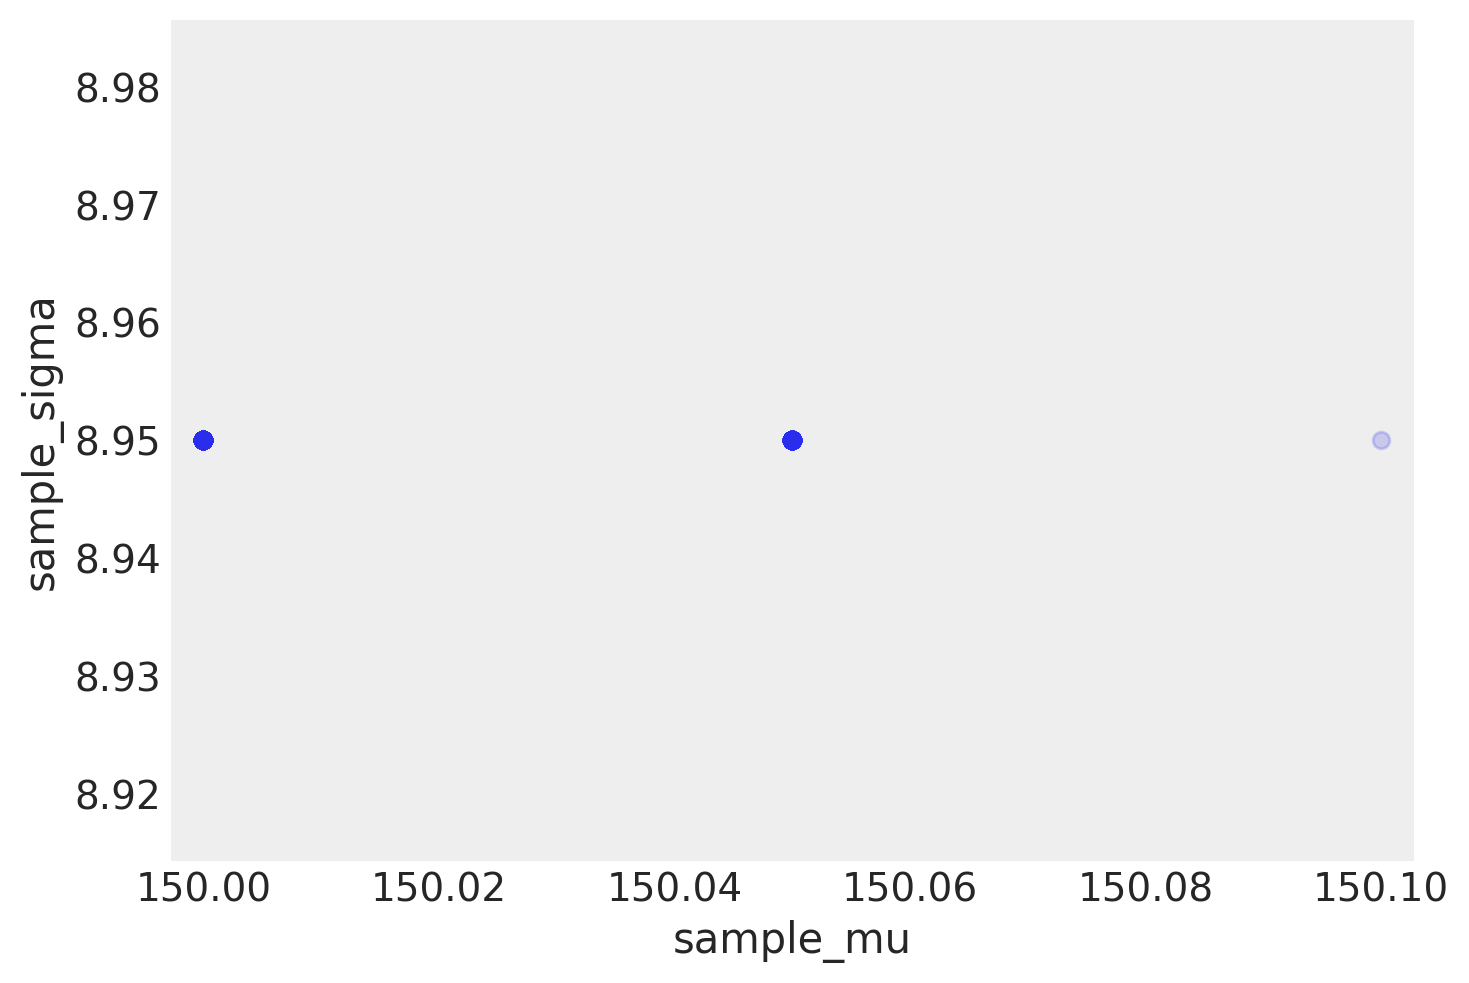

<IPython.core.display.Javascript object>

In [67]:
sample_rows = np.random.choice(
    np.arange(len(post)), size=10000, replace=True, p=(post_prob / post_prob.sum())
)
sample_mu = post[:, 0][sample_rows]
sample_sigma = post[:, 1][sample_rows]

plt.plot(sample_mu, sample_sigma, "o", alpha=0.05)
plt.axis("equal")
plt.grid(False)
plt.xlabel("sample_mu")
plt.ylabel("sample_sigma")

# Code 4.21 (something probably wrong with my code)


## R

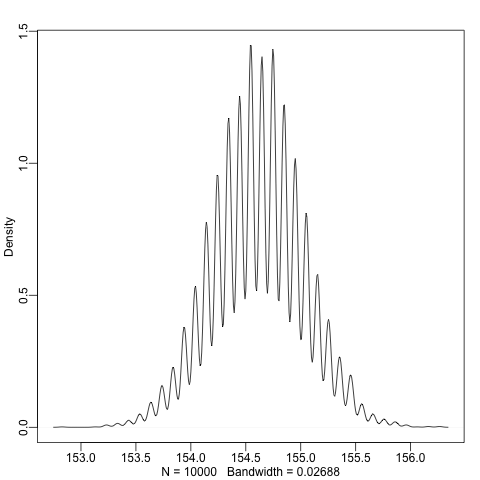

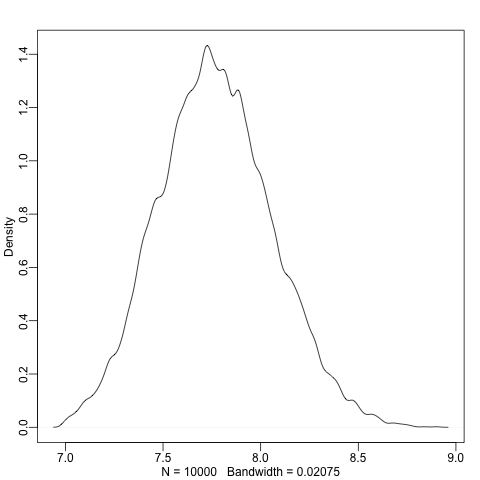

<IPython.core.display.Javascript object>

In [85]:
%%R

dens( sample.mu )
dens( sample.sigma )



## Python


/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/density_utils.py:620: RuntimeWarning: invalid value encountered in double_scalars
  x_std = (((x ** 2).sum() / x_len) - (x.sum() / x_len) ** 2) ** 0.5
/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/density_utils.py:770: UserWarning: Something failed when estimating the bandwidth. Please check your data
  warnings.warn("Something failed when estimating the bandwidth. Please check your data")
/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning: divide by zero encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5
/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/density_utils.py:783: RuntimeWarning: invalid value encountered in true_divide
  pdf /= bw * (2 * np.pi) ** 0.5


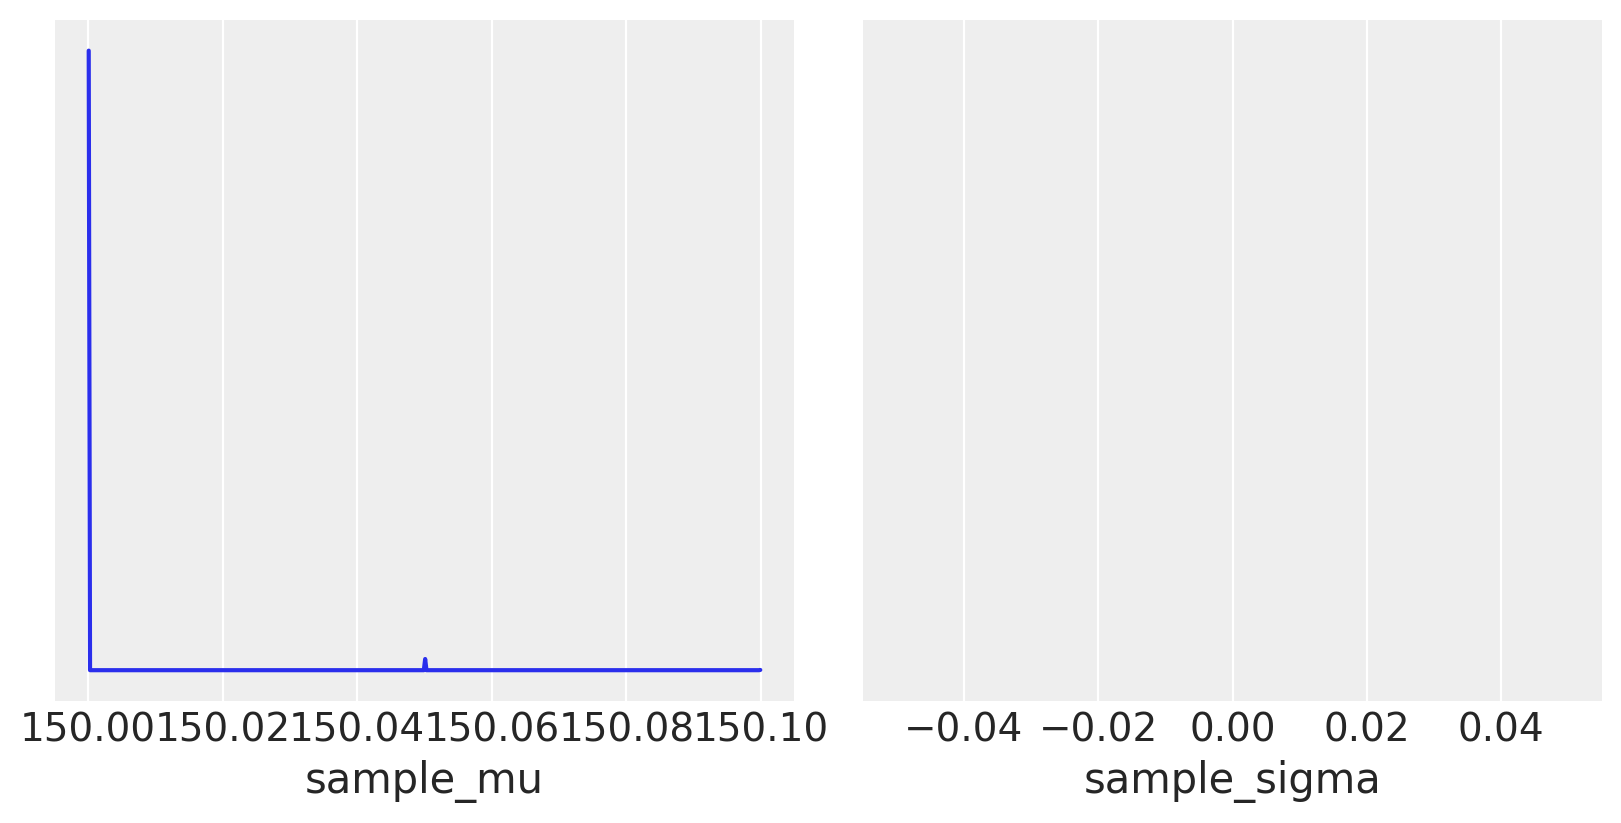

<IPython.core.display.Javascript object>

In [69]:
_, ax = plt.subplots(1, 2, figsize=(8, 4))
az.plot_kde(sample_mu, ax=ax[0])
ax[0].set_xlabel("sample_mu")
ax[0].set_yticks([])
az.plot_kde(sample_sigma, ax=ax[1])
ax[1].set_xlabel("sample_sigma")
ax[1].set_yticks([])

# Code 4.22 (answers prob not right)

Summarize the widths of these densities with posterior compatibility intervals.

## R

In [72]:
%%R

print(PI( sample.mu ))

print(PI( sample.sigma ))

      5%      94% 
153.9394 155.2525 
      5%      94% 
7.323232 8.252525 


<IPython.core.display.Javascript object>

## Python


In [71]:
az.hdi(sample_mu), az.hdi(sample_sigma)

(array([150., 150.]), array([8.95, 8.95]))

<IPython.core.display.Javascript object>

# Code 4.23 and 4.24 (plots not matching)

4.23 Sample 20 random heights from the original list.

4.24 Repeat all the code from the previous subsection, modified to focus on the 20 heights in d3 rather than the original data

## R

In [86]:
%%R

d3 <- sample( d2$height , size=20 )

<IPython.core.display.Javascript object>

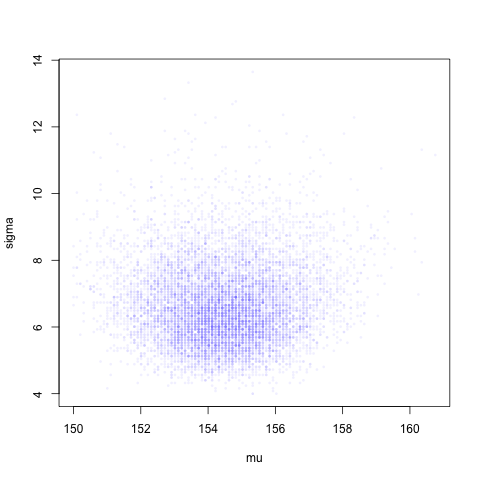

<IPython.core.display.Javascript object>

In [87]:
%%R 

mu.list <- seq( from=150, to=170 , length.out=200 )
sigma.list <- seq( from=4 , to=20 , length.out=200 )
post2 <- expand.grid( mu=mu.list , sigma=sigma.list )
post2$LL <- sapply( 1:nrow(post2) , function(i)
    sum( dnorm( d3 , mean=post2$mu[i] , sd=post2$sigma[i] ,
    log=TRUE ) ) )
post2$prod <- post2$LL + dnorm( post2$mu , 178 , 20 , TRUE ) +
    dunif( post2$sigma , 0 , 50 , TRUE )
post2$prob <- exp( post2$prod - max(post2$prod) )
sample2.rows <- sample( 1:nrow(post2) , size=1e4 , replace=TRUE ,
    prob=post2$prob )
sample2.mu <- post2$mu[ sample2.rows ]
sample2.sigma <- post2$sigma[ sample2.rows ]
plot( sample2.mu , sample2.sigma , cex=0.5 ,
    col=col.alpha(rangi2,0.1) ,
    xlab="mu" , ylab="sigma" , pch=16 )

## Python


In [88]:
d3 = np.random.choice(d2.height, 20)
post2 = np.mgrid[150:170:0.1, 4:20:0.1].reshape(2, -1).T

likelihood2 = [
    sum(stats.norm.logpdf(d3, loc=post2[:, 0][i], scale=post2[:, 1][i]))
    for i in range(len(post2))
]

post_prod2 = (
    likelihood2
    + stats.norm.logpdf(post2[:, 0], loc=178, scale=20)
    + stats.uniform.logpdf(post2[:, 1], loc=0, scale=50)
)

post_prob2 = np.exp(post_prod2 - max(post_prod2))

sample_rows2 = np.random.choice(
    np.arange(len(post2)), size=10000, replace=True, p=(post_prob2 / post_prob2.sum())
)
sample_mu2 = post2[:, 0][sample_rows2]
sample_sigma2 = post2[:, 1][sample_rows2]

<IPython.core.display.Javascript object>

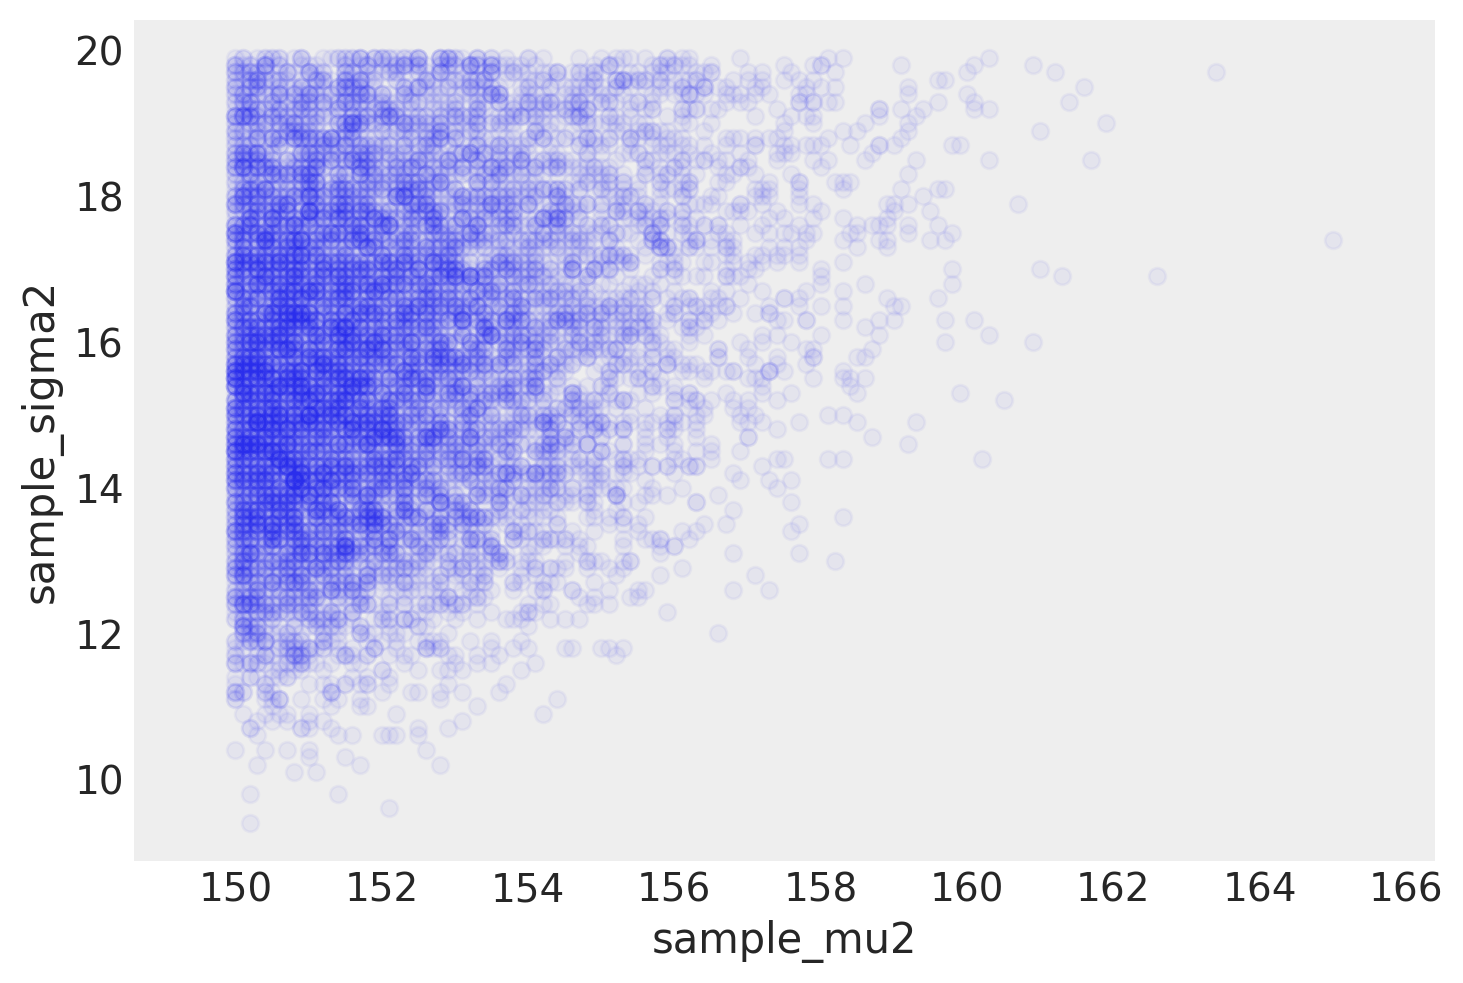

<IPython.core.display.Javascript object>

In [89]:
plt.plot(sample_mu2, sample_sigma2, "o", alpha=0.05)
plt.axis("equal")
plt.xlabel("sample_mu2")
plt.ylabel("sample_sigma2")
plt.grid(False)

# Code 4.26  (I think code is back on track with new dataset)

**Execute Python only cells due to memory demands with PyMC.**

Finding the posterior distribution with quadratic approximation.


## R

In [94]:
%%R

data(Howell1)
d <- Howell1
d2 <- d[ d$age >= 18 , ]

head(d2)

   height   weight age male
1 151.765 47.82561  63    1
2 139.700 36.48581  63    0
3 136.525 31.86484  65    0
4 156.845 53.04191  41    1
5 145.415 41.27687  51    0
6 163.830 62.99259  35    1


<IPython.core.display.Javascript object>

## Python


In [16]:
d = pd.read_csv("../data/a_input/Howell1.csv", sep=";", header=0)
d2 = d[d.age >= 18]
d2.head()

height     weight   age  male
0  151.765  47.825606  63.0     1
1  139.700  36.485807  63.0     0
2  136.525  31.864838  65.0     0
3  156.845  53.041914  41.0     1
4  145.415  41.276872  51.0     0

<IPython.core.display.Javascript object>

# Code 4.27

Define the variables in `alist`.

## R

In [95]:
%%R

flist <- alist(
 height ~ dnorm( mu , sigma ) ,
 mu ~ dnorm( 178 , 20 ) ,
 sigma ~ dunif( 0 , 50 )
)


<IPython.core.display.Javascript object>

## Python


In [17]:
with pm.Model() as m4_1:
    mu = pm.Normal("mu", mu=178, sd=20)
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    height = pm.Normal("height", mu=mu, sd=sigma, observed=d2.height)

<IPython.core.display.Javascript object>

# Code 4.28

**Not outputting R code due to crashing**

Fit the model

## R

In [97]:
%%R

m4.1 <- quap( flist , data=d2 )

<IPython.core.display.Javascript object>

## Python

From [pymc-devs](https://github.com/pymc-devs/resources/blob/master/Rethinking_2/Chp_04.ipynb):
We could use a quadratic approximation like McElreath does in his book and we did in code 2.6. But Using PyMC3 is really simple to just sample from the model using a "sampler method". Most common sampler methods are members of the Markov Chain Monte Carlo Method (MCMC) family (for details read Section 2.4.3 and Chapter 8 of Statistical Rethinking).

PyMC3 comes with various samplers. Some samplers are more suited than others for certain type of variable (and/or problems). For now we are going to let PyMC3 choose the sampler for us. PyMC3 also tries to provide a reasonable starting point for the simulation. By default PyMC3 uses the same adaptive procedure as in STAN 'jitter+adapt_diag', which starts with a identity mass matrix and then adapts a diagonal based on the variance of the tuning samples.

You can read more details of PyMC3 [here](https://docs.pymc.io/notebooks/getting_started.html).

In [18]:
# This crashed when I had both R and Python running the first time

with m4_1:
    trace_4_1 = pm.sample(1000, tune=1000)

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


<IPython.core.display.Javascript object>

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'mu'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

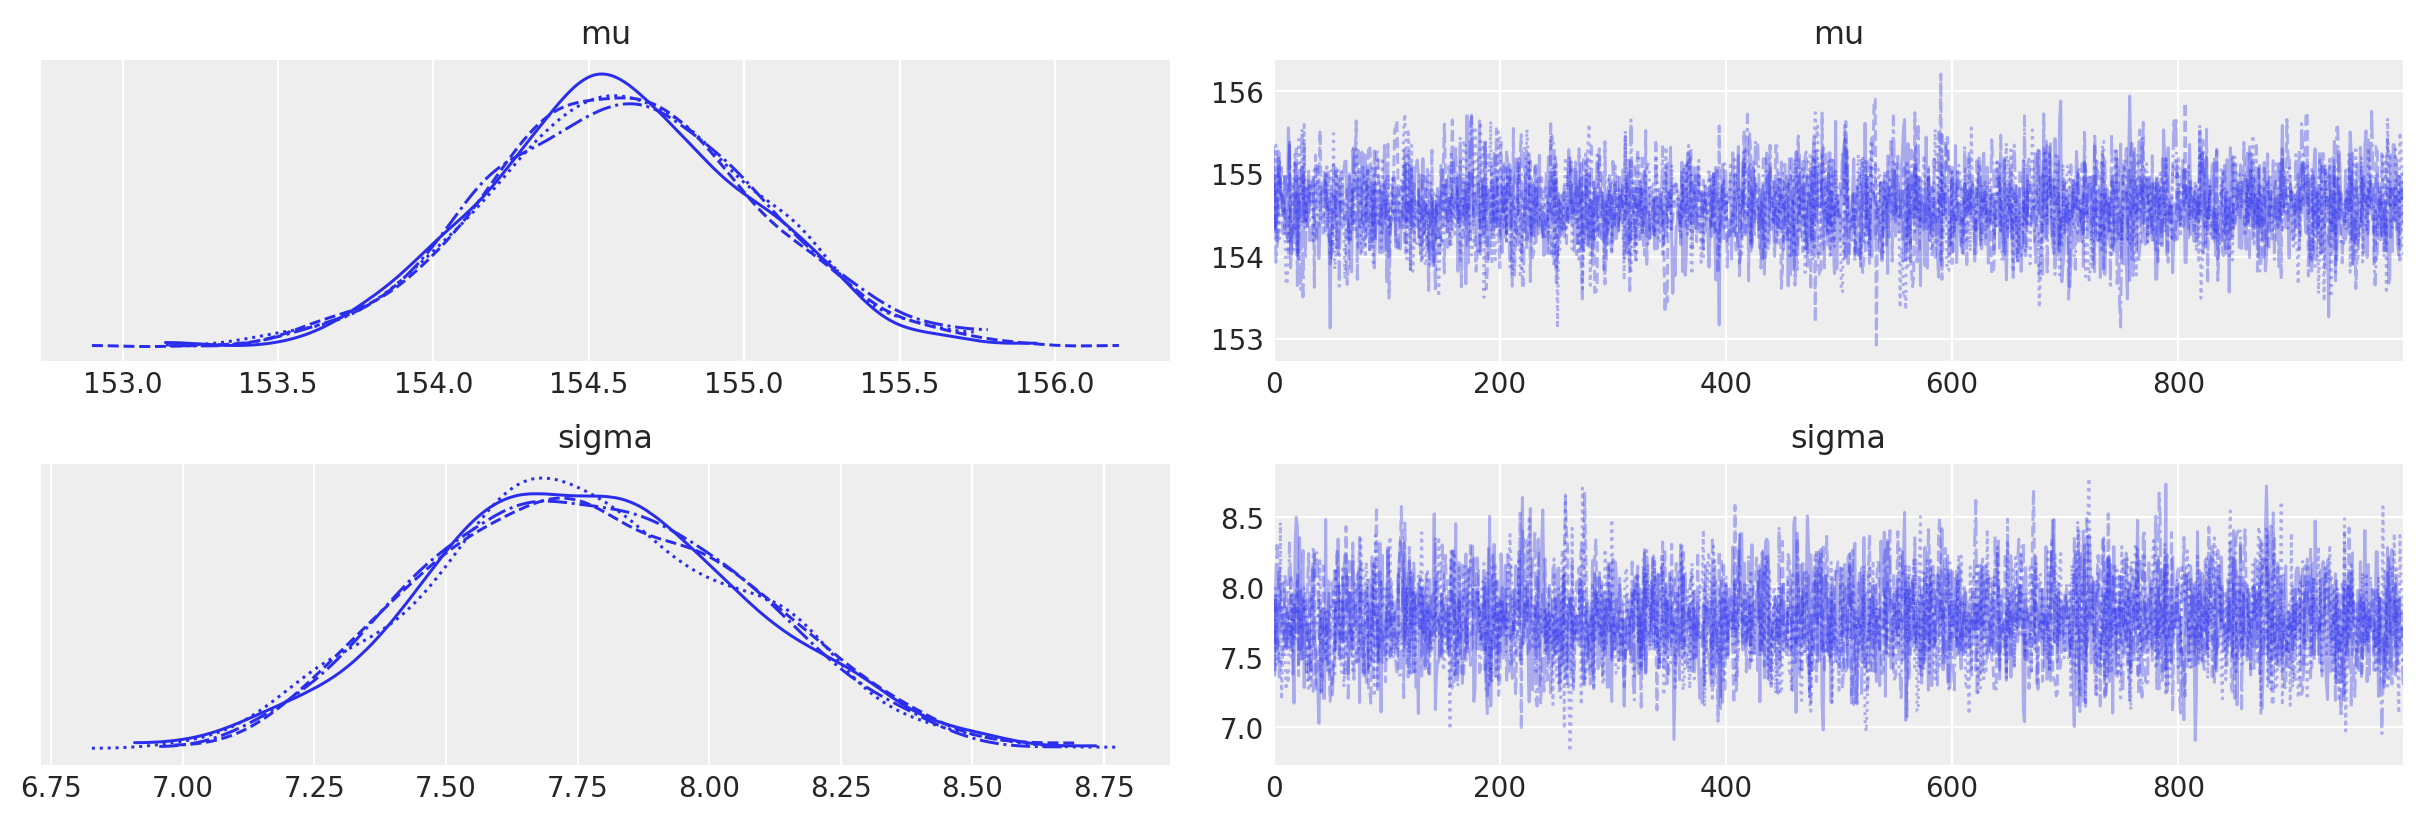

<IPython.core.display.Javascript object>

In [19]:
az.plot_trace(trace_4_1)
# this function lets you check the samples values

# Code 4.29

Look at the posterior distribution.

## R

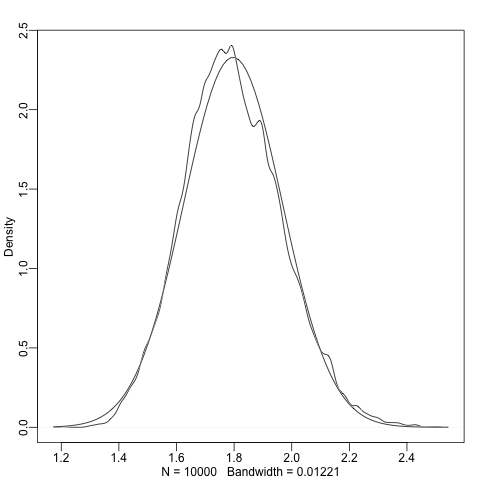

<IPython.core.display.Javascript object>

In [17]:
%%R

precis( m4.1 )

## Python


In [20]:
az.summary(trace_4_1, round_to=2, kind="stats")

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


mean    sd  hdi_5.5%  hdi_94.5%
mu     154.60  0.43    153.96     155.30
sigma    7.77  0.30      7.27       8.24

<IPython.core.display.Javascript object>

In [10]:
# presumed preferred code given warning
with m4_1:
    trace_4_1 = pm.sample(1000, tune=1000, return_inferencedata=True)
    print(az.summary(trace_4_1, round_to=2, kind="stats"))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


         mean    sd  hdi_5.5%  hdi_94.5%
mu     154.60  0.42    153.96     155.28
sigma    7.77  0.29      7.30       8.23


<IPython.core.display.Javascript object>

In [11]:
# presumed preferred code given warning, showing with return_inferencedata=False
with m4_1:
    trace_4_1 = pm.sample(1000, tune=1000, return_inferencedata=False)
    print(az.summary(trace_4_1, round_to=2, kind="stats"))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.
The acceptance probability does not match the target. It is 0.8882375764035535, but should be close to 0.8. Try to increase the number of tuning steps.


         mean    sd  hdi_5.5%  hdi_94.5%
mu     154.62  0.42    153.93     155.26
sigma    7.77  0.29      7.31       8.23


<IPython.core.display.Javascript object>

# Code 4.30

Starting values for quap.

## R

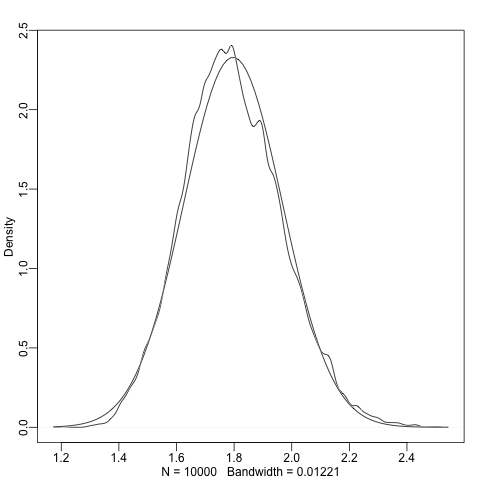

<IPython.core.display.Javascript object>

In [17]:
%%R

start <- list(
    mu=mean(d2$height),
    sigma=sd(d2$height)
)
m4.1 <- quap( flist , data=d2 , start=start )

## Python


In [21]:
with pm.Model() as m4_1:
    mu = pm.Normal("mu", mu=178, sd=20, testval=d2.height.mean())
    sigma = pm.Uniform("sigma", lower=0, upper=50, testval=d2.height.std())
    height = pm.Normal("height", mu=mu, sd=sigma, observed=d2.height)
    trace_4_1 = pm.sample(1000, tune=1000)

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


<IPython.core.display.Javascript object>

# Code 4.31

Starting values for quap.

## R

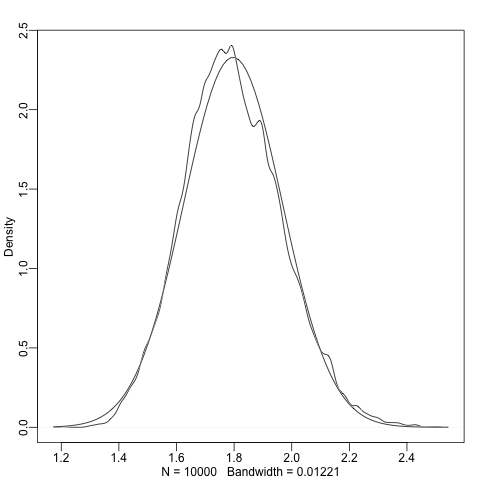

<IPython.core.display.Javascript object>

In [17]:
%%R

m4.2 <- quap(
    alist(
        height ~ dnorm( mu , sigma ) ,
        mu ~ dnorm( 178 , 0.1 ) ,
        sigma ~ dunif( 0 , 50 )
    ) , data=d2 )
precis( m4.2 )

## Python


In [22]:
with pm.Model() as m4_2:
    mu = pm.Normal("mu", mu=178, sd=0.1)
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    height = pm.Normal("height", mu=mu, sd=sigma, observed=d2.height)
    trace_4_2 = pm.sample(1000, tune=1000)
az.summary(trace_4_2, round_to=2, kind="stats")

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.
/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


mean    sd  hdi_5.5%  hdi_94.5%
mu     177.86  0.10    177.70     178.02
sigma   24.59  0.95     23.15      26.12

<IPython.core.display.Javascript object>

# Code 4.32

See matrix of variances and covariances following quadratic approximation construction.

## R

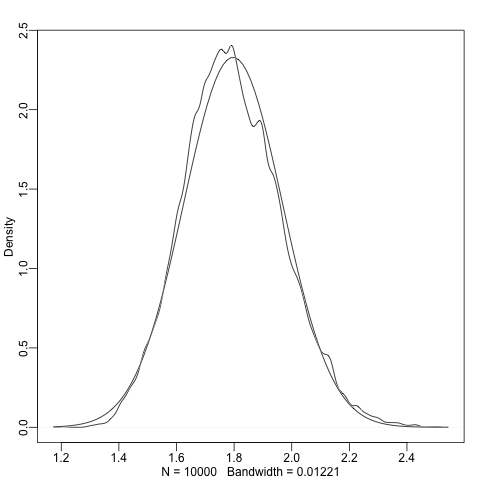

<IPython.core.display.Javascript object>

In [17]:
%%R

vcov( m4.1 )



## Python


In [23]:
trace_df = pm.trace_to_dataframe(trace_4_1)
trace_df.cov()

mu     sigma
mu     0.170347  0.001803
sigma  0.001803  0.090175

<IPython.core.display.Javascript object>

# Code 4.33

A variance-covariance matrix can be factored into two elements: (1) a vector of variances for the parameters and (2) a correlation matrix that tells us how changes in any parameter lead to correlated changes in the others. This decomposition is usually easier to understand.

## R

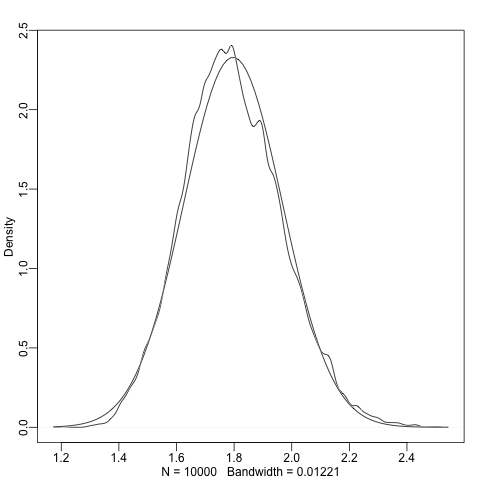

<IPython.core.display.Javascript object>

In [17]:
%%R

diag( vcov( m4.1 ))

cov2cor( vcov( m4.1 ) )

## Python


In [24]:
np.diag(trace_df.cov())

array([0.17034711, 0.09017513])

<IPython.core.display.Javascript object>

# Code 4.34

Now instead of sampling single values from a simple Gaussian distribution, we sample vectors of values from a multi-dimensional Gaussian distribution.

## R

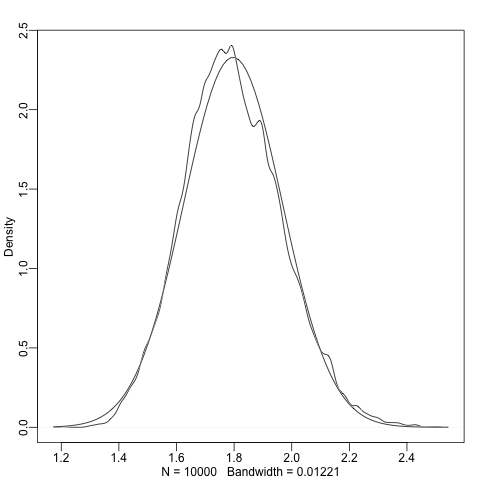

<IPython.core.display.Javascript object>

In [17]:
%%R

post <- extract.samples( m4.1 , n=1e4 )
head(post)

## Python

We did not use the quadratic approximation, instead we use a MCMC method to sample from the posterior. Thus, we already have samples. We can do something like

In [25]:
trace_df.head()

mu     sigma
0  155.400635  7.694262
1  154.892758  8.033243
2  154.550894  7.734319
3  154.512390  8.175420
4  154.416480  8.260447

<IPython.core.display.Javascript object>

Or directly from the trace (we are getting the first ten samples of sigma)

In [26]:
trace_4_1["sigma"][:10]

array([7.69426165, 8.03324281, 7.7343193 , 8.1754202 , 8.2604466 ,
       7.34001662, 7.42460096, 8.21194252, 8.23295721, 8.37327639])

<IPython.core.display.Javascript object>

# Code 4.35 (LEFT OFF HERE)

Starting values for quap.

**It has been a time suck to get through this code so I'll stop here and look at the code on the repo.**

## R

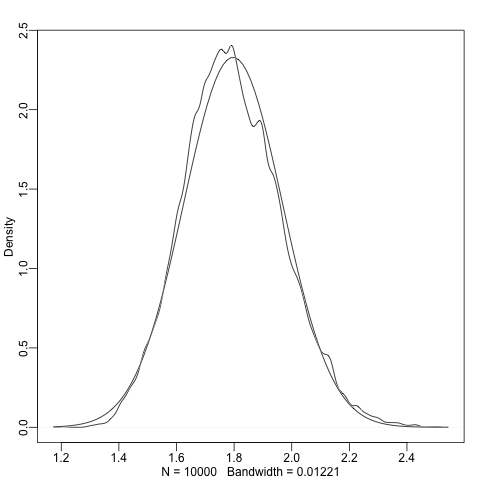

<IPython.core.display.Javascript object>

In [17]:
%%R

start <- list(
    mu=mean(d2$height),
    sigma=sd(d2$height)
)
m4.1 <- quap( flist , data=d2 , start=start )

## Python


In [12]:
with pm.Model() as m4_1:
    mu = pm.Normal("mu", mu=178, sd=20, testval=d2.height.mean())
    sigma = pm.Uniform("sigma", lower=0, upper=50, testval=d2.height.std())
    height = pm.Normal("height", mu=mu, sd=sigma, observed=d2.height)
    trace_4_1 = pm.sample(1000, tune=1000)

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


<IPython.core.display.Javascript object>

# Code 4.30

Starting values for quap.

## R

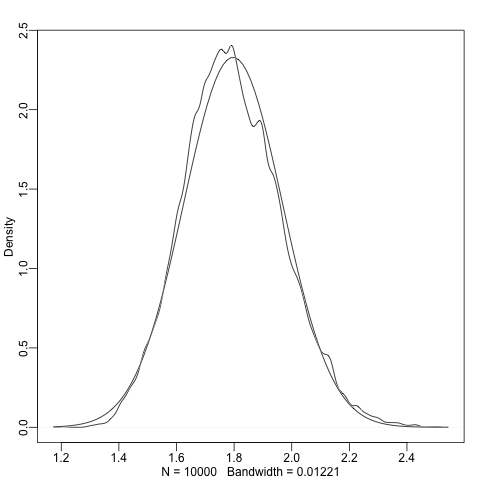

<IPython.core.display.Javascript object>

In [17]:
%%R

start <- list(
    mu=mean(d2$height),
    sigma=sd(d2$height)
)
m4.1 <- quap( flist , data=d2 , start=start )

## Python


In [12]:
with pm.Model() as m4_1:
    mu = pm.Normal("mu", mu=178, sd=20, testval=d2.height.mean())
    sigma = pm.Uniform("sigma", lower=0, upper=50, testval=d2.height.std())
    height = pm.Normal("height", mu=mu, sd=sigma, observed=d2.height)
    trace_4_1 = pm.sample(1000, tune=1000)

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


<IPython.core.display.Javascript object>

# Code 4.30

Starting values for quap.

## R

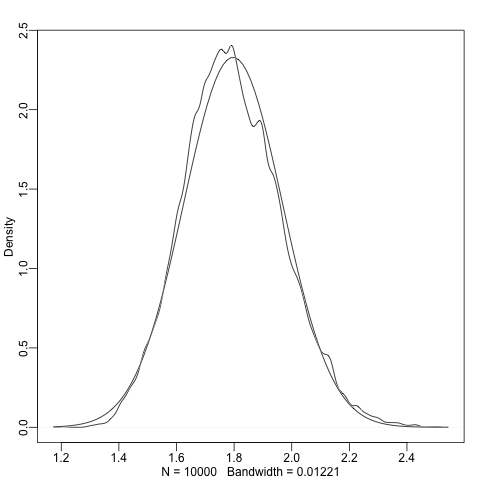

<IPython.core.display.Javascript object>

In [17]:
%%R

start <- list(
    mu=mean(d2$height),
    sigma=sd(d2$height)
)
m4.1 <- quap( flist , data=d2 , start=start )

## Python


In [12]:
with pm.Model() as m4_1:
    mu = pm.Normal("mu", mu=178, sd=20, testval=d2.height.mean())
    sigma = pm.Uniform("sigma", lower=0, upper=50, testval=d2.height.std())
    height = pm.Normal("height", mu=mu, sd=sigma, observed=d2.height)
    trace_4_1 = pm.sample(1000, tune=1000)

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


<IPython.core.display.Javascript object>

# Code 4.30

Starting values for quap.

## R

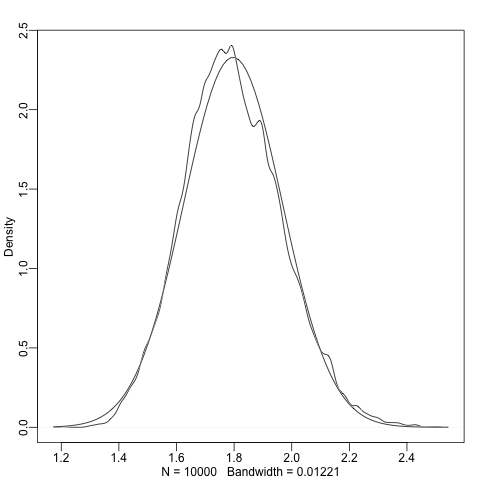

<IPython.core.display.Javascript object>

In [17]:
%%R

start <- list(
    mu=mean(d2$height),
    sigma=sd(d2$height)
)
m4.1 <- quap( flist , data=d2 , start=start )

## Python


In [12]:
with pm.Model() as m4_1:
    mu = pm.Normal("mu", mu=178, sd=20, testval=d2.height.mean())
    sigma = pm.Uniform("sigma", lower=0, upper=50, testval=d2.height.std())
    height = pm.Normal("height", mu=mu, sd=sigma, observed=d2.height)
    trace_4_1 = pm.sample(1000, tune=1000)

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


<IPython.core.display.Javascript object>

# Code 4.30

Starting values for quap.

## R

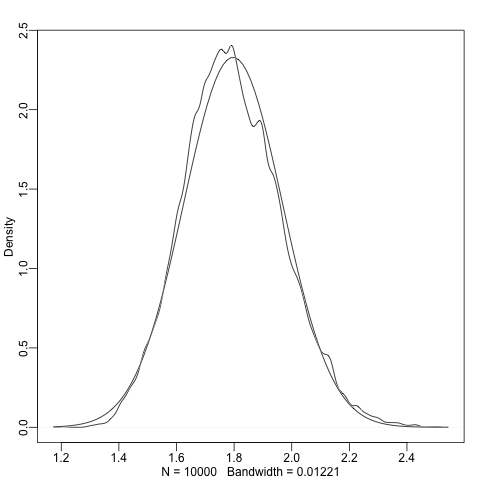

<IPython.core.display.Javascript object>

In [17]:
%%R

start <- list(
    mu=mean(d2$height),
    sigma=sd(d2$height)
)
m4.1 <- quap( flist , data=d2 , start=start )

## Python


In [12]:
with pm.Model() as m4_1:
    mu = pm.Normal("mu", mu=178, sd=20, testval=d2.height.mean())
    sigma = pm.Uniform("sigma", lower=0, upper=50, testval=d2.height.std())
    height = pm.Normal("height", mu=mu, sd=sigma, observed=d2.height)
    trace_4_1 = pm.sample(1000, tune=1000)

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


<IPython.core.display.Javascript object>

# Code 4.30

Starting values for quap.

## R

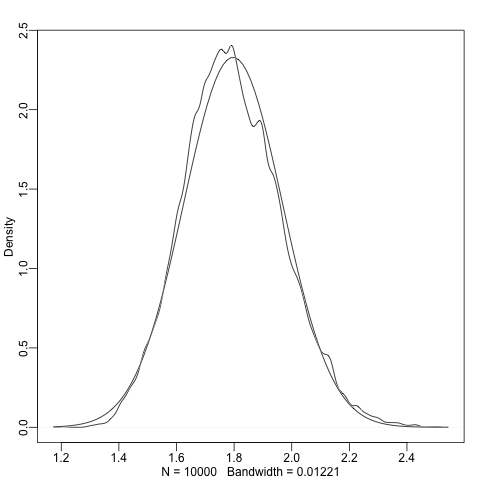

<IPython.core.display.Javascript object>

In [17]:
%%R

start <- list(
    mu=mean(d2$height),
    sigma=sd(d2$height)
)
m4.1 <- quap( flist , data=d2 , start=start )

## Python


In [12]:
with pm.Model() as m4_1:
    mu = pm.Normal("mu", mu=178, sd=20, testval=d2.height.mean())
    sigma = pm.Uniform("sigma", lower=0, upper=50, testval=d2.height.std())
    height = pm.Normal("height", mu=mu, sd=sigma, observed=d2.height)
    trace_4_1 = pm.sample(1000, tune=1000)

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


<IPython.core.display.Javascript object>

# Code 4.30

Starting values for quap.

## R

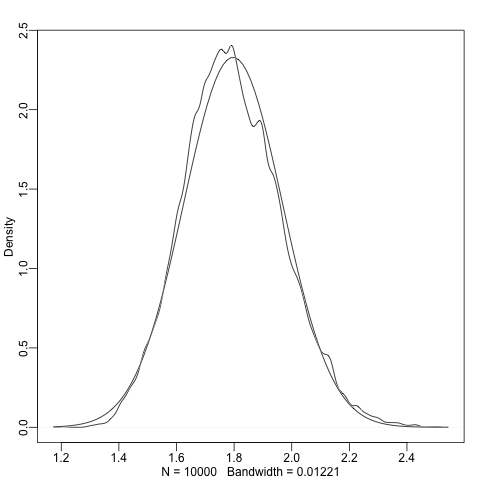

<IPython.core.display.Javascript object>

In [17]:
%%R

start <- list(
    mu=mean(d2$height),
    sigma=sd(d2$height)
)
m4.1 <- quap( flist , data=d2 , start=start )

## Python


In [12]:
with pm.Model() as m4_1:
    mu = pm.Normal("mu", mu=178, sd=20, testval=d2.height.mean())
    sigma = pm.Uniform("sigma", lower=0, upper=50, testval=d2.height.std())
    height = pm.Normal("height", mu=mu, sd=sigma, observed=d2.height)
    trace_4_1 = pm.sample(1000, tune=1000)

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


<IPython.core.display.Javascript object>

# Follow-up for me


# Appendix: Environment and system parameters

In [12]:
%watermark -n -u -v -iv -w

Last updated: Thu Feb 18 2021

Python implementation: CPython
Python version       : 3.8.6
IPython version      : 7.20.0

numpy     : 1.20.1
matplotlib: 3.3.4
arviz     : 0.11.1
pandas    : 1.2.1
seaborn   : 0.11.1
json      : 2.0.9
pymc3     : 3.11.0
scipy     : 1.6.0

Watermark: 2.1.0



<IPython.core.display.Javascript object>

In [13]:
# Custom scripts to show packages and versions in this notebook
def imports():
    import types

    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            yield val.__name__


imported_packages = list(imports())

from active_pkg import show_pkg_vers_in_nb

show_pkg_vers_in_nb(imported_packages)

# Name                    Version                   Build  Channel
arviz                     0.11.1                   pypi_0    pypi
matplotlib                3.3.4                    pypi_0    pypi
numpy                     1.20.1                   pypi_0    pypi
pandas                    1.2.1                    pypi_0    pypi
pymc3                     3.11.0                   pypi_0    pypi
scipy                     1.6.0                    pypi_0    pypi
seaborn                   0.11.1                   pypi_0    pypi


<IPython.core.display.Javascript object>